In [1]:
# ────────────────────────────────────────────────────────────
# Set up the environment and helper functions
# ────────────────────────────────────────────────────────────

# Load standard libraries for file handling and data
import os
from glob import glob
import numpy as np
import pandas as pd

# Import image processing tools
import tifffile as tf
from skimage.io import imread
from skimage.measure import label, regionprops, regionprops_table

# Bring in scientific and statistical routines
from scipy.spatial import cKDTree, distance_matrix
from scipy.stats import mannwhitneyu
from scipy.optimize import curve_fit

# Prepare plotting and machine learning utilities
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold, GroupKFold,
    cross_val_score
)

# Fix the random seed and set up clean plotting defaults
np.random.seed(42)
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.dpi'] = 150

# Define where our data lives and where we'll save results
DATA_DIR = "/Users/asus/Downloads/MSc Final Project Stuff/2D_processed_time_lapse_datasets"
CSV_DIR  = "/Users/asus/Downloads/MSc Final Project Stuff/CodeBuilding"
OUTPUT_DIR = "/Users/asus/Downloads/MSc Final Project Stuff/outputs_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Helper to save figures in a consistent place
def save_fig(fig, name):
    path = os.path.join(OUTPUT_DIR, f"{name}.png")
    fig.savefig(path, bbox_inches='tight')
    print(f"Saved figure: {path}")

# Helper to export DataFrames as CSV files
def export_df(df, name):
    path = os.path.join(OUTPUT_DIR, f"{name}.csv")
    df.to_csv(path, index=False)
    print(f"Wrote CSV: {path}")

Found 10 WT stacks in /Users/asus/Downloads/MSc Final Project Stuff/2D_processed_time_lapse_datasets\WT
Found 6 MUT stacks in /Users/asus/Downloads/MSc Final Project Stuff/2D_processed_time_lapse_datasets\MUT
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\stack_file_list.csv
Loaded marker quantifications from /Users/asus/Downloads/MSc Final Project Stuff/CodeBuilding\tert_muSC-quantification_all.csv: 59 rows, 4 columns


,Type,Indicator,Injured,Uninjured
0,Mutant,Pax7,17,8
1,Mutant,Pax7,16,9
2,Mutant,Pax7,13,7
3,Mutant,Pax7,12,8
4,Mutant,Pax7,11,6


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\quant_preview.csv
Using WT sample file: /Users/asus/Downloads/MSc Final Project Stuff/2D_processed_time_lapse_datasets\WT\WT-1.tif
Using MUT sample file: /Users/asus/Downloads/MSc Final Project Stuff/2D_processed_time_lapse_datasets\MUT\MUT-1.tif

WT sample (WT-1.tif):
  • Number of frames : 122
  • Frame dimensions : 1024 × 1024
  • Data type        : uint16
  • Pixel intensity  : 0 to 38

MUT sample (MUT-1.tif):
  • Number of frames : 121
  • Frame dimensions : 1024 × 1024
  • Data type        : uint16
  • Pixel intensity  : 0 to 36

Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\initial_frame_comparison.png


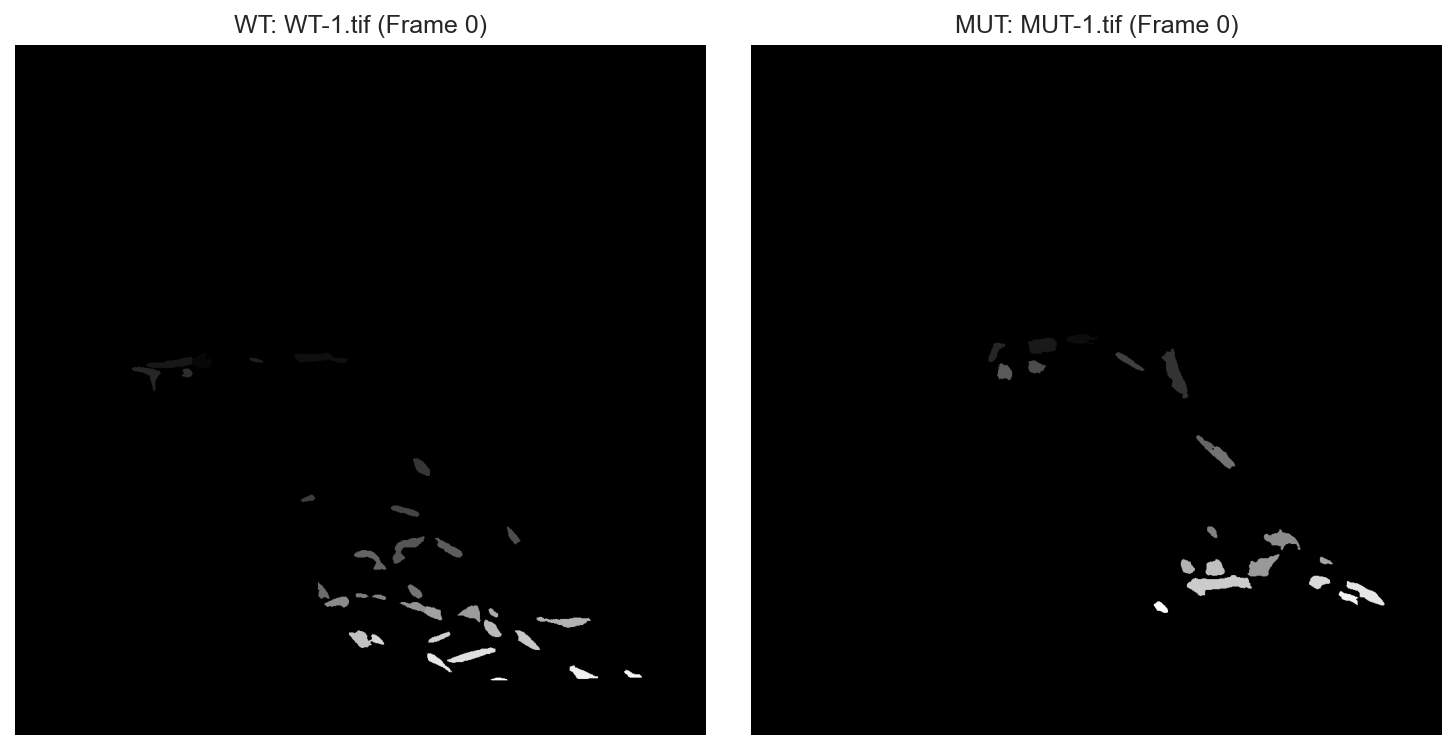

In [2]:
# ────────────────────────────────────────────────────────────
# Load data files and inspect sample images
# ────────────────────────────────────────────────────────────


# 1. Gather all WT and MUT TIFF stack file paths
wt_dir  = os.path.join(DATA_DIR, "WT")
mut_dir = os.path.join(DATA_DIR, "MUT")

wt_files  = sorted(glob(os.path.join(wt_dir,  "*.tif")))
mut_files = sorted(glob(os.path.join(mut_dir, "*.tif")))

print(f"Found {len(wt_files)} WT stacks in {wt_dir}")
print(f"Found {len(mut_files)} MUT stacks in {mut_dir}")

# Export the file lists for reference
file_list_df = pd.DataFrame({
    "file_path": wt_files + mut_files,
    "Genotype": ["WT"] * len(wt_files) + ["MUT"] * len(mut_files)
})
export_df(file_list_df, "stack_file_list")

# 2. Load the marker quantification CSV
marker_csv = os.path.join(CSV_DIR, "tert_muSC-quantification_all.csv")
quant_df = pd.read_csv(marker_csv)
print(f"Loaded marker quantifications from {marker_csv}: "
      f"{quant_df.shape[0]} rows, {quant_df.shape[1]} columns")
display(quant_df.head())
export_df(quant_df.head(20), "quant_preview")

# 3. Inspect the first frame of one representative WT and MUT stack
wt_sample = wt_files[0]
mut_sample = mut_files[0]

print(f"Using WT sample file: {wt_sample}")
print(f"Using MUT sample file: {mut_sample}\n")

wt_stack  = imread(wt_sample)
mut_stack = imread(mut_sample)

def summarize_stack(name, stack, path):
    print(f"{name} sample ({os.path.basename(path)}):")
    print(f"  • Number of frames : {stack.shape[0]}")
    print(f"  • Frame dimensions : {stack.shape[1]} × {stack.shape[2]}")
    print(f"  • Data type        : {stack.dtype}")
    print(f"  • Pixel intensity  : {stack.min()} to {stack.max()}\n")

summarize_stack("WT",  wt_stack,  wt_sample)
summarize_stack("MUT", mut_stack, mut_sample)

# Display Frame 0 side by side with titles that include the file names
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(wt_stack[0], cmap='gray')
axes[0].set_title(f"WT: {os.path.basename(wt_sample)} (Frame 0)")
axes[0].axis('off')

axes[1].imshow(mut_stack[0], cmap='gray')
axes[1].set_title(f"MUT: {os.path.basename(mut_sample)} (Frame 0)")
axes[1].axis('off')

plt.tight_layout()
save_fig(fig, "initial_frame_comparison")


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\objects_df.csv
Using WT frame 0 and MUT frame 0 for overlay
Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\centroid_overlay_dynamic.png
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\tracks_df.csv
Linked 4263 distinct tracks across all stacks.


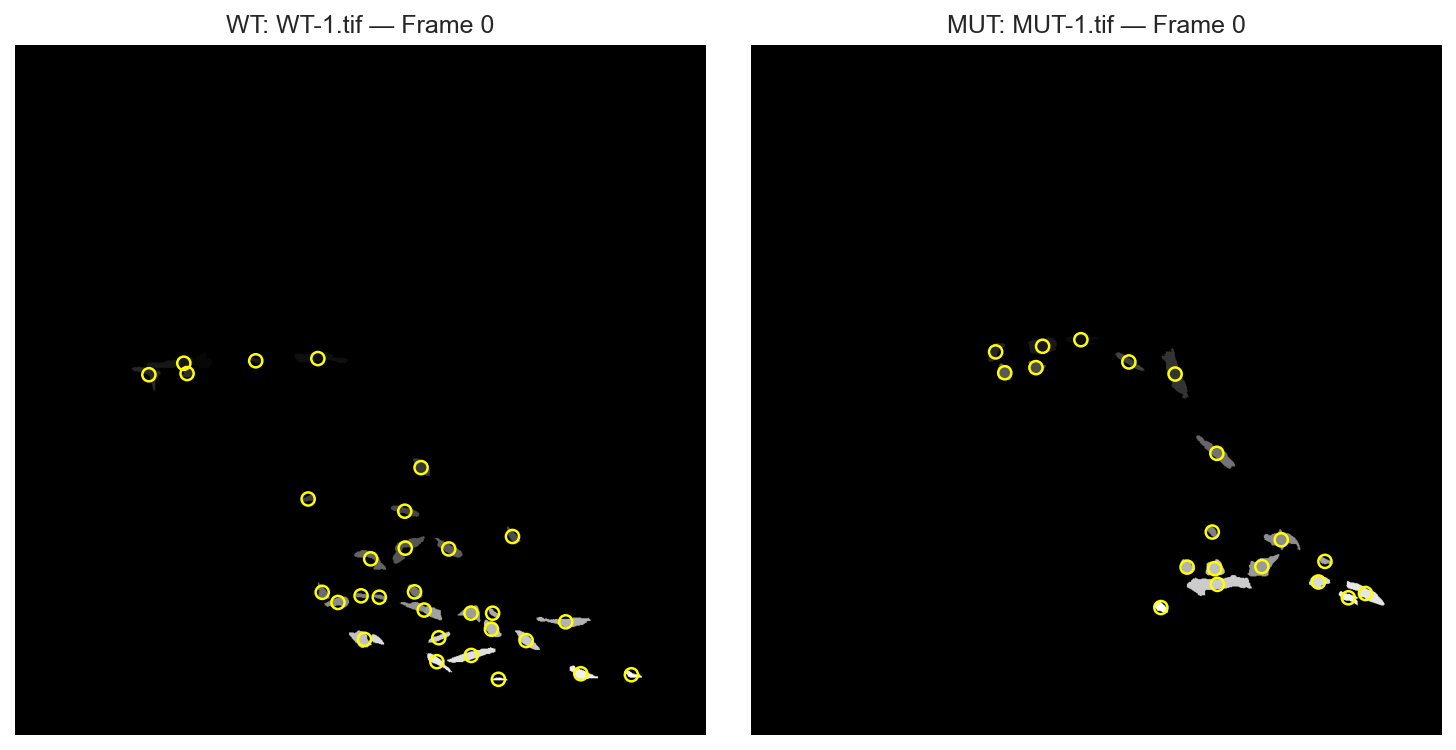

In [3]:
# ────────────────────────────────────────────────────────────
# Object Detection, Dynamic Centroid Overlay & Initial Tracking
# ────────────────────────────────────────────────────────────

# 1. Detect objects in every frame and assemble into objects_df
records = []
for stack_path, genotype in [(p, "WT") for p in wt_files] + [(p, "MUT") for p in mut_files]:
    stack      = tf.imread(stack_path)
    stack_name = os.path.basename(stack_path)
    for frame_idx, frame in enumerate(stack):
        # create binary mask and label connected regions
        labeled = label(frame > 0)
        props   = regionprops_table(
            labeled,
            properties=[
                "label", "area", "perimeter",
                "eccentricity", "solidity", "orientation",
                "centroid"
            ]
        )
        df = pd.DataFrame(props).rename(columns={
            "centroid-0": "centroid_y",
            "centroid-1": "centroid_x"
        })
        # annotate with context
        df["stack"]    = stack_name
        df["frame"]    = frame_idx
        df["Genotype"] = genotype
        records.append(df)

objects_df = pd.concat(records, ignore_index=True)
export_df(objects_df, "objects_df")

# 2. Find the first frame that actually has detections for a given stack
def first_nonempty_frame(df, stack_name):
    """Return the first frame index where we have detections for this stack."""
    # look only at rows belonging to that stack
    subset = df[df["stack"] == stack_name]
    for f in sorted(subset["frame"].unique()):
        if not subset[subset["frame"] == f].empty:
            return f
    return None

# pick one WT and one MUT file
sample_wt = wt_files[0]
sample_mut= mut_files[0]
base_wt   = os.path.basename(sample_wt)
base_mut  = os.path.basename(sample_mut)

# choose the first non-empty frame for each
frame_wt0  = first_nonempty_frame(objects_df, base_wt)
frame_mut0 = first_nonempty_frame(objects_df, base_mut)
print(f"Using WT frame {frame_wt0} and MUT frame {frame_mut0} for overlay")

# extract detections and images
df_wt0   = objects_df[
    (objects_df["stack"] == base_wt)  &
    (objects_df["frame"] == frame_wt0)
]
df_mut0  = objects_df[
    (objects_df["stack"] == base_mut) &
    (objects_df["frame"] == frame_mut0)
]
img_wt0  = imread(sample_wt)[frame_wt0]
img_mut0 = imread(sample_mut)[frame_mut0]

# plot centroids on the chosen frames
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_wt0, cmap="gray")
axes[0].scatter(df_wt0["centroid_x"], df_wt0["centroid_y"],
                s=40, edgecolor="yellow", facecolor="none", linewidth=1.2)
axes[0].set_title(f"WT: {base_wt} — Frame {frame_wt0}")
axes[0].axis("off")

axes[1].imshow(img_mut0, cmap="gray")
axes[1].scatter(df_mut0["centroid_x"], df_mut0["centroid_y"],
                s=40, edgecolor="yellow", facecolor="none", linewidth=1.2)
axes[1].set_title(f"MUT: {base_mut} — Frame {frame_mut0}")
axes[1].axis("off")

plt.tight_layout()
save_fig(fig, "centroid_overlay_dynamic")

# 3. Link centroids into tracks via nearest‐neighbor
def link_tracks(df_objects, max_disp=30):
    tracks  = []
    next_tid = 0

    for stack_name, grp in df_objects.groupby("stack", sort=False):
        frames     = sorted(grp["frame"].unique())
        prev_coords = None
        prev_ids    = None

        for t in frames:
            sub    = grp[grp["frame"] == t].copy()
            coords = sub[["centroid_y", "centroid_x"]].values

            if t == frames[0]:
                # start a new track for every detection
                ids = list(range(next_tid, next_tid + len(sub)))
                next_tid += len(sub)
            else:
                tree  = cKDTree(prev_coords)
                dists, idxs = tree.query(coords, distance_upper_bound=max_disp)
                ids   = []
                for d, i in zip(dists, idxs):
                    if i < len(prev_ids) and d <= max_disp:
                        ids.append(prev_ids[i])
                    else:
                        ids.append(next_tid)
                        next_tid += 1

            sub["track_id"] = ids
            tracks.append(sub)
            prev_coords, prev_ids = coords, ids

    tdf = pd.concat(tracks, ignore_index=True)
    tdf = tdf.sort_values(["stack", "track_id", "frame"])
    diffs = tdf.groupby(["stack", "track_id"])[["centroid_x", "centroid_y"]].diff().fillna(0)
    tdf["dx"]            = diffs["centroid_x"]
    tdf["dy"]            = diffs["centroid_y"]
    tdf["step_distance"] = np.hypot(tdf["dx"], tdf["dy"])
    tdf["stationary"]    = tdf["step_distance"] < 1e-6

    return tdf

tracks_df = link_tracks(objects_df)
export_df(tracks_df, "tracks_df")

print(f"Linked {tracks_df['track_id'].nunique()} distinct tracks across all stacks.")

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\track_metrics.csv
Per-track movement metrics (first 5 tracks):


,stack,track_id,Genotype,num_frames,total_path_length,net_displacement,directionality_ratio,mean_speed,max_speed,n_stationary,persistence_fraction
0,MUT-1.tif,2815,MUT,7.0,54.262985,4.420743,0.081469,7.751855,23.970868,1.0,0.081469
1,MUT-1.tif,2816,MUT,1.0,0.000000,0.000000,NaN,0.000000,0.000000,1.0,NaN
2,MUT-1.tif,2817,MUT,15.0,109.755676,29.340924,0.267329,7.317045,32.211210,1.0,0.267329
3,MUT-1.tif,2818,MUT,7.0,131.329183,37.026664,0.281938,18.761312,38.198791,1.0,0.281938
4,MUT-1.tif,2819,MUT,12.0,61.593071,39.352121,0.638905,5.132756,11.909970,1.0,0.638905


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\mean_speed_by_genotype.png


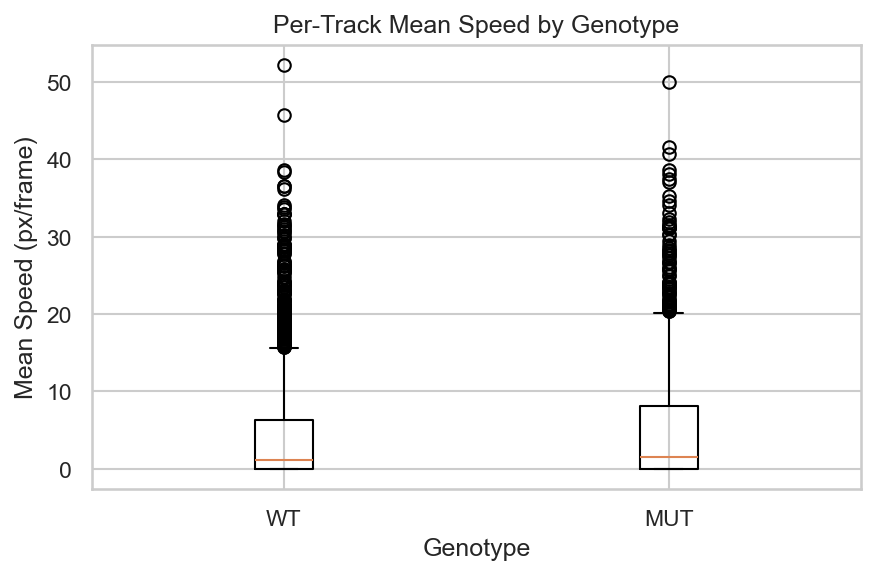

In [4]:
# ────────────────────────────────────────────────────────────
# Compute and Export Per-Track Movement Metrics
# ────────────────────────────────────────────────────────────

# For each track, compute summary metrics of movement
def compute_track_metrics(df):
    """
    Given a DataFrame for one track (sorted by frame), return:
      - num_frames: number of frames observed
      - total_path_length: sum of step distances
      - net_displacement: straight-line distance from first to last point
      - directionality_ratio: net_displacement / total_path_length
      - mean_speed: average step distance (pixels/frame)
      - max_speed: maximum step distance
      - n_stationary: number of frames with effectively zero movement
      - persistence_fraction: same as directionality_ratio
    """
    num_frames = df.shape[0]
    total_path = df["step_distance"].sum()
    # straight-line distance
    net_disp = np.hypot(
        df["centroid_x"].iloc[-1] - df["centroid_x"].iloc[0],
        df["centroid_y"].iloc[-1] - df["centroid_y"].iloc[0]
    )
    directionality = net_disp / total_path if total_path > 0 else np.nan

    return pd.Series({
        "num_frames":           num_frames,
        "total_path_length":    total_path,
        "net_displacement":     net_disp,
        "directionality_ratio": directionality,
        "mean_speed":           df["step_distance"].mean(),
        "max_speed":            df["step_distance"].max(),
        "n_stationary":         int((df["step_distance"] < 1e-6).sum()),
        "persistence_fraction": directionality
    })

# Apply to each track within each genotype
track_metrics = (
    tracks_df
    .sort_values(["stack","track_id","frame"])
    .groupby(["stack","track_id","Genotype"], sort=False)
    .apply(compute_track_metrics)
    .reset_index()
)

# export the metrics to CSV for supplemental files
export_df(track_metrics, "track_metrics")

# Show a few rows to verify
print("Per-track movement metrics (first 5 tracks):")
display(track_metrics.head())

# ────────────────────────────────────────────────────────────
# Visualize mean speed by genotype
# ────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(6,4))
# prepare data
wt_speeds = track_metrics[track_metrics.Genotype == "WT"]["mean_speed"].dropna()
mut_speeds= track_metrics[track_metrics.Genotype == "MUT"]["mean_speed"].dropna()

ax.boxplot([wt_speeds, mut_speeds], labels=["WT","MUT"])
ax.set_title("Per-Track Mean Speed by Genotype")
ax.set_ylabel("Mean Speed (px/frame)")
ax.set_xlabel("Genotype")

plt.tight_layout()
save_fig(fig, "mean_speed_by_genotype")

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\shape_dynamics_df.csv
Per-track shape dynamics (first 5 rows):


,stack,track_id,Genotype,area_mean,area_delta_mean,area_delta_max,area_slope,perimeter_mean,perimeter_delta_mean,perimeter_delta_max,...,eccentricity_delta_max,eccentricity_slope,solidity_mean,solidity_delta_mean,solidity_delta_max,solidity_slope,orientation_mean,orientation_delta_mean,orientation_delta_max,orientation_slope
0,MUT-1.tif,2815,MUT,423.142857,9.500000,390,1.322581,105.286884,0.436887,83.041631,...,0.282217,-0.004451,0.862626,0.008989,0.100245,0.014302,-0.376233,0.008487,3.126988,0.199072
1,MUT-1.tif,2816,MUT,793.000000,0.000000,0,NaN,119.254834,0.000000,0.000000,...,0.000000,NaN,0.918888,0.000000,0.000000,NaN,-1.447608,0.000000,0.000000,NaN
2,MUT-1.tif,2817,MUT,261.600000,-7.571429,142,-6.851227,74.121431,-2.116244,33.106602,...,0.038264,-0.003546,0.855600,0.008110,0.148039,0.008034,-0.326243,0.021192,2.007801,0.004048
3,MUT-1.tif,2818,MUT,878.000000,-118.666667,1637,-147.051471,162.988853,-12.323521,233.622366,...,0.106268,0.003428,0.822995,-0.013383,0.225501,-0.011829,0.382356,-0.013658,0.158039,-0.043026
4,MUT-1.tif,2819,MUT,450.250000,-1.000000,216,-5.479021,126.146128,-2.317398,57.941125,...,0.043071,-0.004584,0.892168,0.002794,0.068288,0.003457,1.065764,0.009907,0.038896,0.011679


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\area_mean_by_genotype.png


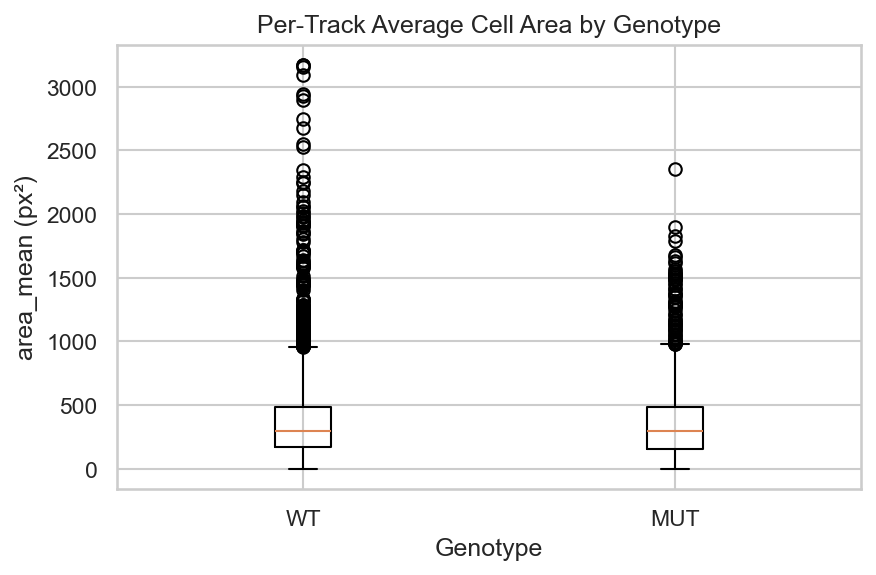

In [5]:
# ────────────────────────────────────────────────────────────
# Compute and Export Per-Track Shape Dynamics Metrics
# ────────────────────────────────────────────────────────────

# Define a helper that summarizes how a single shape feature changes over time within one track
def compute_shape_dynamics(df, feature):
    """
    Given a track’s DataFrame (sorted by frame) and a feature name, return:
      - {feature}_mean       : average value
      - {feature}_delta_mean : mean frame-to-frame change
      - {feature}_delta_max  : largest absolute single-step change
      - {feature}_slope      : linear trend of feature vs. frame
    """
    values = df[feature].values
    frames = df["frame"].values
    diffs  = np.diff(values)

    slope = np.polyfit(frames, values, 1)[0] if len(values) > 1 else np.nan

    return {
        f"{feature}_mean":        np.mean(values),
        f"{feature}_delta_mean":  np.mean(diffs) if diffs.size > 0 else 0,
        f"{feature}_delta_max":   np.max(np.abs(diffs)) if diffs.size > 0 else 0,
        f"{feature}_slope":       slope
    }

# List of shape features to process
shape_features = ["area", "perimeter", "eccentricity", "solidity", "orientation"]

# Compute per-track shape dynamics for each track
shape_records = []
for (stack, track_id, geno), group in tracks_df.groupby(
        ["stack", "track_id", "Genotype"], sort=False
    ):
    traj = group.sort_values("frame")
    record = {"stack": stack, "track_id": track_id, "Genotype": geno}
    for feat in shape_features:
        record.update(compute_shape_dynamics(traj, feat))
    shape_records.append(record)

shape_dynamics_df = pd.DataFrame(shape_records)
export_df(shape_dynamics_df, "shape_dynamics_df")

# Preview the first few rows of the shape dynamics table
print("Per-track shape dynamics (first 5 rows):")
display(shape_dynamics_df.head())

# ────────────────────────────────────────────────────────────
# Visualize per-track average cell area by genotype
# ────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(6, 4))
wt_area = shape_dynamics_df.loc[
    shape_dynamics_df.Genotype == "WT", "area_mean"
].dropna()
mut_area = shape_dynamics_df.loc[
    shape_dynamics_df.Genotype == "MUT", "area_mean"
].dropna()

ax.boxplot([wt_area, mut_area], labels=["WT", "MUT"])
ax.set_title("Per-Track Average Cell Area by Genotype")
ax.set_ylabel("area_mean (px²)")
ax.set_xlabel("Genotype")

plt.tight_layout()
save_fig(fig, "area_mean_by_genotype")

In [6]:
# ────────────────────────────────────────────────────────────
# Compute and Export Per-Track Diffusion Parameters
# (MSD, Power-Law & PRW, keyed by true track_id)
# ────────────────────────────────────────────────────────────

from scipy.optimize import curve_fit

# 1. Dictionary of real trajectories by track_id
trajectories = {
    int(tid): grp.sort_values("frame")[["centroid_x","centroid_y"]].values
    for tid, grp in tracks_df.groupby("track_id")
}

# 2. Short-lag MSD helper
def compute_msd(traj, max_lag=10):
    n = len(traj)
    lags = min(max_lag, n - 1)
    msd = []
    for lag in range(1, lags+1):
        disp = traj[lag:] - traj[:-lag]
        msd.append(np.mean(np.sum(disp**2, axis=1)))
    return np.array(msd)

# 3. Power-law fit helper
def fit_power_law(msd_vals):
    if len(msd_vals) < 2:
        return np.nan, np.nan
    taus = np.arange(1, len(msd_vals)+1)
    α, logK = np.polyfit(np.log(taus), np.log(msd_vals), 1)
    return α, np.exp(logK)

# 4. Compute α & K per track
plaw_rows = []
for tid, traj in trajectories.items():
    msd_vals = compute_msd(traj)
    α, K     = fit_power_law(msd_vals)
    plaw_rows.append({"track_id": tid, "alpha": α, "K": K})
plaw_df = pd.DataFrame(plaw_rows)
export_df(plaw_df, "powerlaw_parameters")

# 5. PRW model helper
def msd_prw(t, D, P):
    return 4 * D * (t - P * (1 - np.exp(-t/P)))

# 6. Fit PRW per track
prw_rows = []
for tid, traj in trajectories.items():
    msd_vals = compute_msd(traj)
    taus     = np.arange(1, len(msd_vals)+1)
    if len(taus) < 2:
        prw_rows.append({"track_id": tid, "D_est": np.nan, "P_est": np.nan})
        continue
    D0 = msd_vals.mean() / (4 * taus.mean()) if taus.mean()>0 else np.nan
    P0 = 1.0
    try:
        popt, _ = curve_fit(msd_prw, taus, msd_vals, p0=[D0,P0], maxfev=5000)
        D_fit, P_fit = popt
    except:
        D_fit, P_fit = np.nan, np.nan
    prw_rows.append({"track_id": tid, "D_est": D_fit, "P_est": P_fit})
prw_df = pd.DataFrame(prw_rows)
export_df(prw_df, "prw_parameters")

# 7. Merge back into track_metrics
track_metrics = (
    track_metrics
      .merge(plaw_df, on="track_id", how="left")
      .merge(prw_df,  on="track_id", how="left")
)
export_df(track_metrics, "track_metrics_with_diffusion")

# 8. Sanity check
present = [c for c in ["alpha","K","D_est","P_est"] if c in track_metrics.columns]
print("Diffusion columns present after merge:", present)

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\powerlaw_parameters.csv


C:\Users\asus\AppData\Local\Temp\ipykernel_29348\63605437.py:43: RuntimeWarning: overflow encountered in exp
  return 4 * D * (t - P * (1 - np.exp(-t/P)))
C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\asus\AppData\Local\Temp\ipykernel_29348\63605437.py:43: RuntimeWarning: overflow encountered in multiply
  return 4 * D * (t - P * (1 - np.exp(-t/P)))


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\prw_parameters.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\track_metrics_with_diffusion.csv
Diffusion columns present after merge: ['alpha', 'K', 'D_est', 'P_est']


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\pair_correlation_summaries.csv
PF-SDF summaries per file:


,source_file,Genotype,r_peak,g_peak,corr_length
0,MUT-1.tif,MUT,3.0,112054.157935,9.0
1,MUT-2.tif,MUT,3.0,79023.636866,11.0
2,MUT-3.tif,MUT,3.0,45425.053541,9.0
3,MUT-5.tif,MUT,3.0,43006.834209,9.0
4,MUT-6.tif,MUT,3.0,41952.019001,11.0
5,MUT-7.tif,MUT,3.0,40627.939182,9.0
6,WT-1.tif,WT,3.0,76840.632427,9.0
7,WT-10.tif,WT,3.0,28767.976860,9.0
8,WT-2.tif,WT,3.0,174053.631831,7.0
9,WT-3.tif,WT,3.0,105265.957759,9.0


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\pair_correlation_mean_sem.png


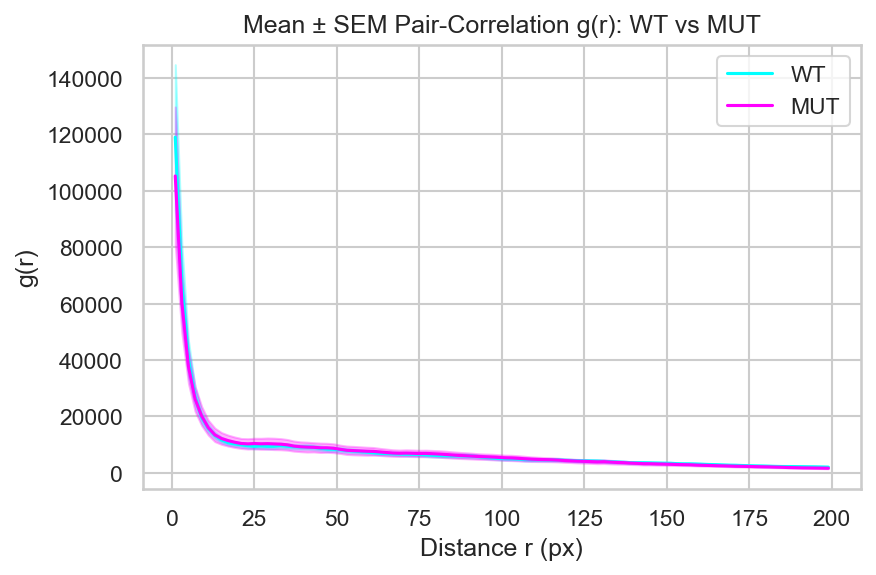

In [7]:
# ────────────────────────────────────────────────────────────
# Compute and Export Pair-Correlation (PF-SDF) Summaries per File
# ────────────────────────────────────────────────────────────

def compute_pair_correlation(centroids, img_shape, max_r=200, bin_width=2):
    """
    Compute radial pair-correlation g(r) for a set of points.
    Returns:
      - r:         bin centers
      - g_r:       pair-correlation values
      - r_peak:    r at first maximum
      - g_peak:    g(r) at that peak
      - corr_len:  distance where g(r) first decays below g_peak/e
    """
    # pairwise distances (upper triangle)
    dmat   = distance_matrix(centroids, centroids)
    dists  = dmat[np.triu_indices_from(dmat, k=1)]
    bins   = np.arange(0, max_r + bin_width, bin_width)
    counts, edges = np.histogram(dists, bins=bins)
    r_centers = (edges[:-1] + edges[1:]) / 2

    # density normalization
    N      = len(centroids)
    area   = img_shape[0] * img_shape[1]
    rho0   = N / area
    shell_areas = np.pi * ((r_centers + bin_width/2)**2 - (r_centers - bin_width/2)**2)
    g_r    = (counts / shell_areas) / rho0

    # find first peak (skip r=0)
    peak_idx = np.argmax(g_r[1:]) + 1
    r_peak   = r_centers[peak_idx]
    g_peak   = g_r[peak_idx]

    # correlation length where g drops below g_peak/e
    threshold = g_peak / np.e
    below = np.where(g_r < threshold)[0]
    corr_len = r_centers[below[0]] if below.size>0 else np.nan

    return r_centers, g_r, r_peak, g_peak, corr_len

# compute g(r) and summaries for each file
pc_rows = []
for fname, grp in tracks_df.groupby("stack"):
    centroids = grp[["centroid_x","centroid_y"]].values
    # determine image shape from one of the stacks
    img = wt_stack if fname.startswith("WT") else mut_stack
    img_shape = img.shape[1], img.shape[2]  # (height, width)

    r_vals, g_vals, r_pk, g_pk, c_len = compute_pair_correlation(centroids, img_shape)
    genotype = grp["Genotype"].iloc[0]

    pc_rows.append({
        "source_file":     fname,
        "Genotype":        genotype,
        "r_vals":          r_vals,
        "g_vals":          g_vals,
        "r_peak":          r_pk,
        "g_peak":          g_pk,
        "corr_length":     c_len
    })

pc_df = pd.DataFrame(pc_rows)
export_df(pc_df.drop(columns=["r_vals","g_vals"]), "pair_correlation_summaries")

# preview the summary table
print("PF-SDF summaries per file:")
display(pc_df[["source_file","Genotype","r_peak","g_peak","corr_length"]])

# ────────────────────────────────────────────────────────────
# Visualize mean ± SEM g(r) across all WT vs MUT files
# ────────────────────────────────────────────────────────────

# stack the r and g arrays
all_r = np.stack(pc_df["r_vals"].values)
all_g = np.stack(pc_df["g_vals"].values)

# boolean masks
wt_mask  = pc_df["Genotype"] == "WT"
mut_mask = pc_df["Genotype"] == "MUT"

r_center = all_r[0]
mean_wt   = np.nanmean(all_g[wt_mask], axis=0)
sem_wt    = np.nanstd(all_g[wt_mask], axis=0) / np.sqrt(wt_mask.sum())
mean_mut  = np.nanmean(all_g[mut_mask], axis=0)
sem_mut   = np.nanstd(all_g[mut_mask], axis=0) / np.sqrt(mut_mask.sum())

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(r_center, mean_wt,  label="WT",  color="cyan")
ax.fill_between(r_center, mean_wt-sem_wt, mean_wt+sem_wt, color="cyan", alpha=0.3)
ax.plot(r_center, mean_mut, label="MUT", color="magenta")
ax.fill_between(r_center, mean_mut-sem_mut, mean_mut+sem_mut, color="magenta", alpha=0.3)

ax.set_xlabel("Distance r (px)")
ax.set_ylabel("g(r)")
ax.set_title("Mean ± SEM Pair-Correlation g(r): WT vs MUT")
ax.legend()

plt.tight_layout()
save_fig(fig, "pair_correlation_mean_sem")

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\per_track_statistical_tests.csv
Ran Mann–Whitney U on 18 metrics (Bonferroni α=0.0028):


,Metric,WT_median,MUT_median,U_statistic,p_value,Significant
0,eccentricity_mean,0.931589,0.913420,2239235.5,1.249749e-07,True
1,orientation_mean,0.610078,0.697744,1868703.5,8.587381e-06,True
2,mean_speed,1.082364,1.445580,1941707.0,8.095788e-03,False
3,max_speed,2.140642,2.703039,1945041.0,1.057552e-02,False
4,total_path_length,2.770250,3.462484,1956536.0,2.505820e-02,False
5,net_displacement,1.507452,2.017109,1967634.0,5.292912e-02,False
6,directionality_ratio,0.431791,0.354874,671364.0,5.933331e-02,False
7,persistence_fraction,0.431791,0.354874,671364.0,5.933331e-02,False
8,num_frames,2.000000,2.000000,1980137.5,1.106517e-01,False
9,eccentricity_delta_mean,0.000000,0.000000,1982839.0,1.290813e-01,False


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\top3_metrics_comparison.png


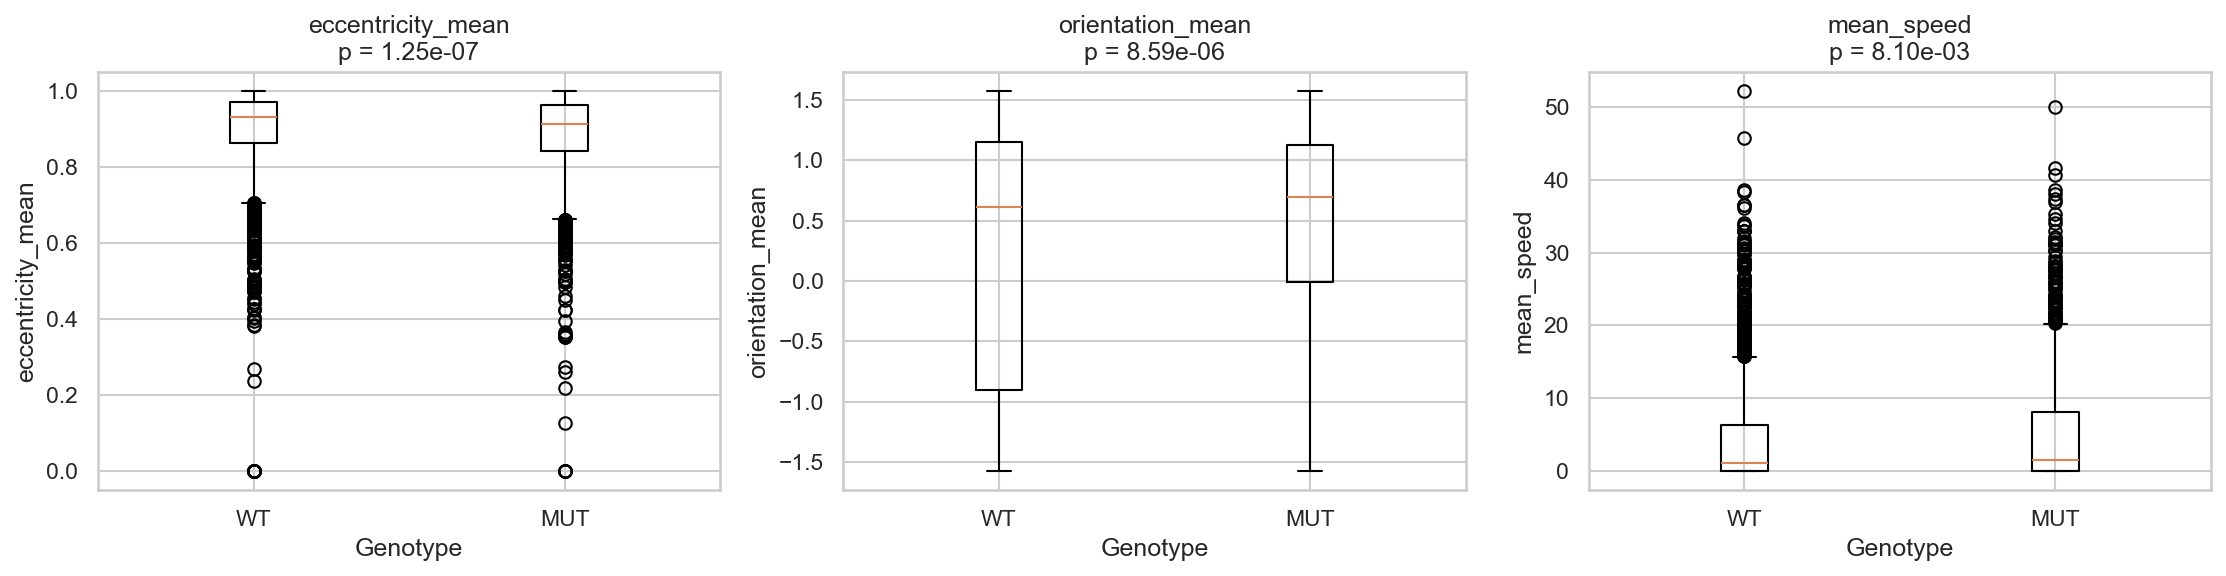

In [8]:
# ────────────────────────────────────────────────────────────
# Statistical Tests on All Per-Track Movement & Shape Metrics
# ────────────────────────────────────────────────────────────

# 1. Identify all shape-mean columns
shape_means = [c for c in shape_dynamics_df.columns if c.endswith("_mean")]

# 2. Merge movement metrics with shape means into a single table
per_track = (
    track_metrics
    .merge(
        shape_dynamics_df[["stack","track_id","Genotype"] + shape_means],
        on=["stack","track_id","Genotype"],
        how="left"
    )
)

# 3. Automatically gather all movement metrics (exclude metadata and diffusion columns)
meta_cols      = ["stack","track_id","Genotype"]
diffusion_cols = ["alpha","K","D_est","P_est"]
movement_metrics = [
    col for col in track_metrics.columns
    if col not in meta_cols + diffusion_cols
]

# 4. Gather all shape metrics
shape_metrics = shape_means

# 5. Combine everything to test
all_metrics = movement_metrics + shape_metrics

# 6. Set Bonferroni-corrected alpha
alpha      = 0.05
alpha_corr = alpha / len(all_metrics)

# 7. Perform Mann–Whitney U test on each metric
test_results = []
for metric in all_metrics:
    wt_vals  = per_track.loc[per_track.Genotype=="WT",  metric].dropna()
    mut_vals = per_track.loc[per_track.Genotype=="MUT", metric].dropna()
    if len(wt_vals) > 0 and len(mut_vals) > 0:
        u_stat, p_val = mannwhitneyu(wt_vals, mut_vals, alternative="two-sided")
        test_results.append({
            "Metric":       metric,
            "WT_median":    np.median(wt_vals),
            "MUT_median":   np.median(mut_vals),
            "U_statistic":  u_stat,
            "p_value":      p_val,
            "Significant":  p_val < alpha_corr
        })

results_df = pd.DataFrame(test_results)
export_df(results_df, "per_track_statistical_tests")

# 8. Display sorted test results
print(f"Ran Mann–Whitney U on {len(all_metrics)} metrics (Bonferroni α={alpha_corr:.4f}):")
display(results_df.sort_values("p_value").reset_index(drop=True))

# 9. Visualize the three most significant metrics
top3 = results_df.nsmallest(3, "p_value")["Metric"].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
for ax, metric in zip(axes, top3):
    wt = per_track.loc[per_track.Genotype=="WT",  metric].dropna()
    mut= per_track.loc[per_track.Genotype=="MUT", metric].dropna()
    ax.boxplot([wt, mut], labels=["WT","MUT"])
    p_val = results_df.loc[results_df.Metric==metric, "p_value"].values[0]
    ax.set_title(f"{metric}\np = {p_val:.2e}")
    ax.set_ylabel(metric)
    ax.set_xlabel("Genotype")

plt.tight_layout()
save_fig(fig, "top3_metrics_comparison")

In [9]:
# ────────────────────────────────────────────────────────────
# Compute and Export Time-Dependent Track Metrics
# ────────────────────────────────────────────────────────────

def compute_temporal_metrics(df):
    """
    Given one track’s DataFrame (sorted by frame), compute:
      - early_speed_mean, late_speed_mean
      - speed_trend_slope, speed_acceleration
      - early_area_mean, late_area_mean
      - area_trend_slope, area_volatility
      - early_eccentricity_mean, late_eccentricity_mean
      - eccentricity_trend_slope
      - temporal_persistence (lag-1 autocorrelation of speed)
      - speed_cv (coefficient of variation)
      - directional_consistency (1 – std(turning angles)/π)
    """
    df = df.sort_values("frame")
    n = len(df)
    # not enough data → return NaNs
    if n < 3:
        return pd.Series({col: np.nan for col in [
            'early_speed_mean','late_speed_mean','speed_trend_slope','speed_acceleration',
            'early_area_mean','late_area_mean','area_trend_slope','area_volatility',
            'early_eccentricity_mean','late_eccentricity_mean','eccentricity_trend_slope',
            'temporal_persistence','speed_cv','directional_consistency'
        ]})

    frames = df["frame"].values
    speeds = df["step_distance"].values
    areas  = df["area"].values
    eccs   = df["eccentricity"].values

    # split into first/last third
    third     = max(n // 3, 1)
    early_idx = slice(0, third)
    late_idx  = slice(-third, None)

    # compute basic means
    early_speed = speeds[early_idx].mean()
    late_speed  = speeds[late_idx].mean()
    speed_slope = np.polyfit(frames, speeds, 1)[0]
    speed_accel = np.polyfit(frames, speeds, 2)[0] if n >= 3 else np.nan

    early_area = areas[early_idx].mean()
    late_area  = areas[late_idx].mean()
    area_slope = np.polyfit(frames, areas, 1)[0]
    area_volatility = np.std(areas) / np.mean(areas) if np.mean(areas) > 0 else np.nan

    early_ecc = eccs[early_idx].mean()
    late_ecc  = eccs[late_idx].mean()
    ecc_slope = np.polyfit(frames, eccs, 1)[0]

    # temporal persistence: speed autocorrelation lag-1
    if n >= 4:
        temp_persist = np.corrcoef(speeds[:-1], speeds[1:])[0,1]
    else:
        temp_persist = np.nan

    speed_cv = np.std(speeds) / np.mean(speeds) if np.mean(speeds) > 0 else np.nan

    # directional consistency: based on turning angles
    dx = df["dx"].values
    dy = df["dy"].values
    angles = []
    for i in range(1, len(dx)-1):
        v1 = np.array([dx[i-1], dy[i-1]])
        v2 = np.array([dx[i],   dy[i]])
        if np.linalg.norm(v1) > 0 and np.linalg.norm(v2) > 0:
            cos_ang = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            cos_ang = np.clip(cos_ang, -1, 1)
            angles.append(np.arccos(cos_ang))
    if angles:
        dir_cons = 1 - (np.std(angles) / np.pi)
    else:
        dir_cons = np.nan

    return pd.Series({
        'early_speed_mean':           early_speed,
        'late_speed_mean':            late_speed,
        'speed_trend_slope':          speed_slope,
        'speed_acceleration':         speed_accel,
        'early_area_mean':            early_area,
        'late_area_mean':             late_area,
        'area_trend_slope':           area_slope,
        'area_volatility':            area_volatility,
        'early_eccentricity_mean':    early_ecc,
        'late_eccentricity_mean':     late_ecc,
        'eccentricity_trend_slope':   ecc_slope,
        'temporal_persistence':       temp_persist,
        'speed_cv':                   speed_cv,
        'directional_consistency':    dir_cons
    })

# apply to every track
temporal_metrics = (
    tracks_df
    .groupby(["stack","track_id","Genotype"], sort=False)
    .apply(compute_temporal_metrics)
    .reset_index()
)

# export for supplemental use
export_df(temporal_metrics, "temporal_metrics")

# quick preview
print("Temporal metrics computed for each track (first 5 rows):")
display(temporal_metrics.head())

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:839: RankWarning: Polyfit may be poorly conditioned
  res = f(group)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:839: RankWarning: Polyfit may be poorly conditioned
  res = f(group)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:839: RankWarning: Polyfit may be poorly conditioned
  res = f(group)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:839: RankWarning: Polyfit may be poorly conditioned
  res = f(group)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:839: RankWarning: Polyfit may be poorly conditioned
  res = f(group)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:839: RankWarning: Polyfit may be poorly conditioned
  res = f(group)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\groupby\ops.py:839: RankWarning: Polyfit may be poorly conditioned
  res = f(group)
C:\ProgramData\anaconda3\li

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\temporal_metrics.csv
Temporal metrics computed for each track (first 5 rows):


,stack,track_id,Genotype,early_speed_mean,late_speed_mean,speed_trend_slope,speed_acceleration,early_area_mean,late_area_mean,area_trend_slope,area_volatility,early_eccentricity_mean,late_eccentricity_mean,eccentricity_trend_slope,temporal_persistence,speed_cv,directional_consistency
0,MUT-1.tif,2815,MUT,0.502130,13.937519,2.920828,-1.091373,460.5,507.5,1.322581,0.302955,0.952431,0.959165,-0.004451,0.313032,1.325220,0.587668
1,MUT-1.tif,2816,MUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MUT-1.tif,2817,MUT,2.910686,5.936040,0.153033,-0.170790,304.6,255.0,-6.851227,0.214857,0.920466,0.895490,-0.003546,0.354861,1.472150,0.633272
3,MUT-1.tif,2818,MUT,6.582446,12.722278,0.125127,-2.746979,1453.5,470.5,-147.051471,0.642569,0.974143,0.963114,0.003428,0.297940,0.694317,0.665681
4,MUT-1.tif,2819,MUT,2.852253,6.619542,0.383237,-0.174919,420.0,372.0,-5.479021,0.236859,0.984283,0.950192,-0.004584,0.314311,0.666360,0.611050


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\temporal_statistical_tests.csv
Ran Mann–Whitney U on 14 temporal metrics (Bonferroni α=0.0036):


,Metric,WT_median,MUT_median,U_statistic,p_value,Significant
0,area_volatility,0.292049,0.347929,305699.0,0.000001,True
1,late_speed_mean,6.601485,9.113869,320557.0,0.000605,True
2,early_eccentricity_mean,0.932106,0.919193,383698.0,0.006043,False
3,early_speed_mean,1.358635,2.017423,330049.0,0.009310,False
4,speed_trend_slope,0.669703,0.836955,339242.0,0.109117,False
5,speed_acceleration,-0.155604,-0.264248,371469.0,0.121270,False
6,late_eccentricity_mean,0.925906,0.922881,368923.5,0.193423,False
7,eccentricity_trend_slope,-0.000209,-0.000081,346434.0,0.368752,False
8,late_area_mean,322.000000,348.000000,346851.5,0.390902,False
9,temporal_persistence,0.206957,0.206962,222512.0,0.410398,False


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\top3_temporal_comparison.png


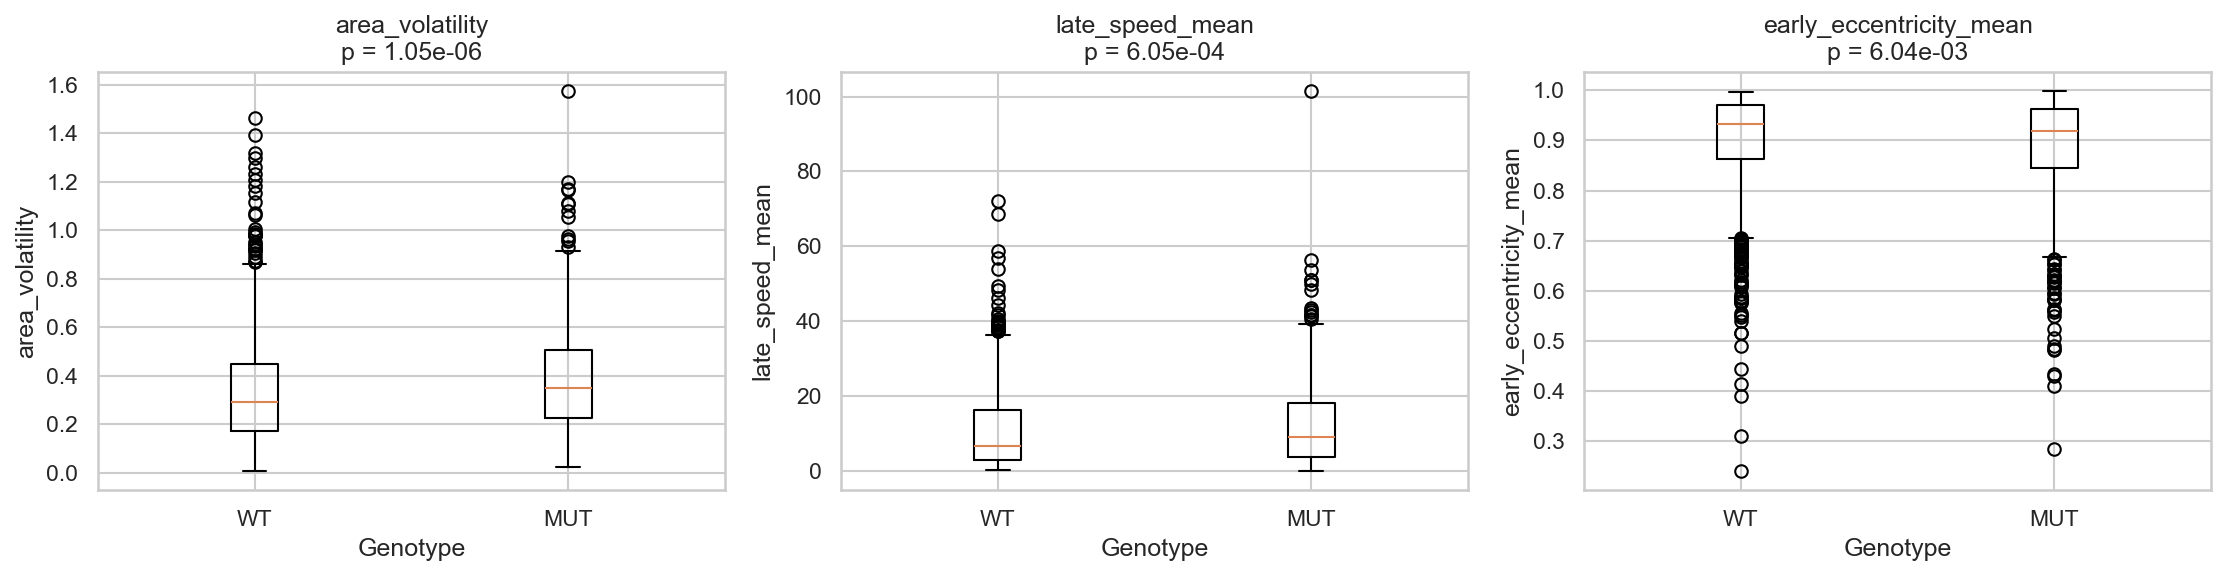

In [10]:
# ────────────────────────────────────────────────────────────
# Statistical Tests on Temporal Features
# ────────────────────────────────────────────────────────────

# 1. Identify the temporal metric columns
temporal_cols = [
    c for c in temporal_metrics.columns
    if c not in ["stack", "track_id", "Genotype"]
]

# 2. Bonferroni‐corrected significance threshold
alpha      = 0.05
alpha_corr = alpha / len(temporal_cols)

# 3. Perform Mann–Whitney U test on each temporal metric
temporal_test_results = []
for metric in temporal_cols:
    wt_vals  = temporal_metrics.loc[temporal_metrics.Genotype=="WT",  metric].dropna()
    mut_vals = temporal_metrics.loc[temporal_metrics.Genotype=="MUT", metric].dropna()
    if len(wt_vals)>0 and len(mut_vals)>0:
        u_stat, p_val = mannwhitneyu(wt_vals, mut_vals, alternative="two-sided")
        temporal_test_results.append({
            "Metric":       metric,
            "WT_median":    np.median(wt_vals),
            "MUT_median":   np.median(mut_vals),
            "U_statistic":  u_stat,
            "p_value":      p_val,
            "Significant":  p_val < alpha_corr
        })

temporal_results_df = pd.DataFrame(temporal_test_results)
export_df(temporal_results_df, "temporal_statistical_tests")

# 4. Display sorted results
print(f"Ran Mann–Whitney U on {len(temporal_cols)} temporal metrics (Bonferroni α={alpha_corr:.4f}):")
display(temporal_results_df.sort_values("p_value").reset_index(drop=True))

# 5. Visualize the three most significant temporal metrics
top3_temporal = temporal_results_df.nsmallest(3, "p_value")["Metric"].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
for ax, metric in zip(axes, top3_temporal):
    wt = temporal_metrics.loc[temporal_metrics.Genotype=="WT",  metric].dropna()
    mut= temporal_metrics.loc[temporal_metrics.Genotype=="MUT", metric].dropna()
    ax.boxplot([wt, mut], labels=["WT","MUT"])
    p_val = temporal_results_df.loc[temporal_results_df.Metric==metric, "p_value"].values[0]
    ax.set_title(f"{metric}\np = {p_val:.2e}")
    ax.set_ylabel(metric)
    ax.set_xlabel("Genotype")

plt.tight_layout()
save_fig(fig, "top3_temporal_comparison")

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\myotome_metrics.csv
Myotome injury response metrics:


,Indicator,Type,total_injured,total_uninjured,injury_ratio,injury_index,injured_cv,uninjured_cv
0,Pax7,Mutant,143,66,0.684211,0.368421,0.219027,0.192847
1,Pax7,WT,163,53,0.754630,0.509259,0.200830,0.207719
2,MyoG,Mutant,210,42,0.833333,0.666667,0.293762,0.430331
3,MyoG,WT,161,41,0.797030,0.594059,0.114949,0.180883
4,GFP,Mutant,142,45,0.759358,0.518717,0.166173,0.436145
5,GFP,WT,146,33,0.815642,0.631285,0.106109,0.318783
6,BrdU,Mutant,228,35,0.866920,0.733840,0.076270,0.397133
7,BrdU,WT,274,50,0.845679,0.691358,0.113925,0.223428
8,GFP/BrdU,Mutant,66,13,0.835443,0.670886,0.215130,0.679366
9,GFP/BrdU,WT,104,25,0.806202,0.612403,0.191021,0.302875


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\myotome_statistical_tests.csv
Myotome tests (Bonferroni α=0.0100):


,Indicator,WT_median,MUT_median,p_value,Significant
0,Pax7,0.750583,0.650000,0.035964,False
1,MyoG,0.804878,0.857143,0.202020,False
2,GFP,0.828029,0.770615,0.352381,False
3,BrdU,0.855995,0.870680,0.422527,False
4,GFP/BrdU,0.803571,0.811765,0.914849,False


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\injury_ratio_by_indicator_type.png


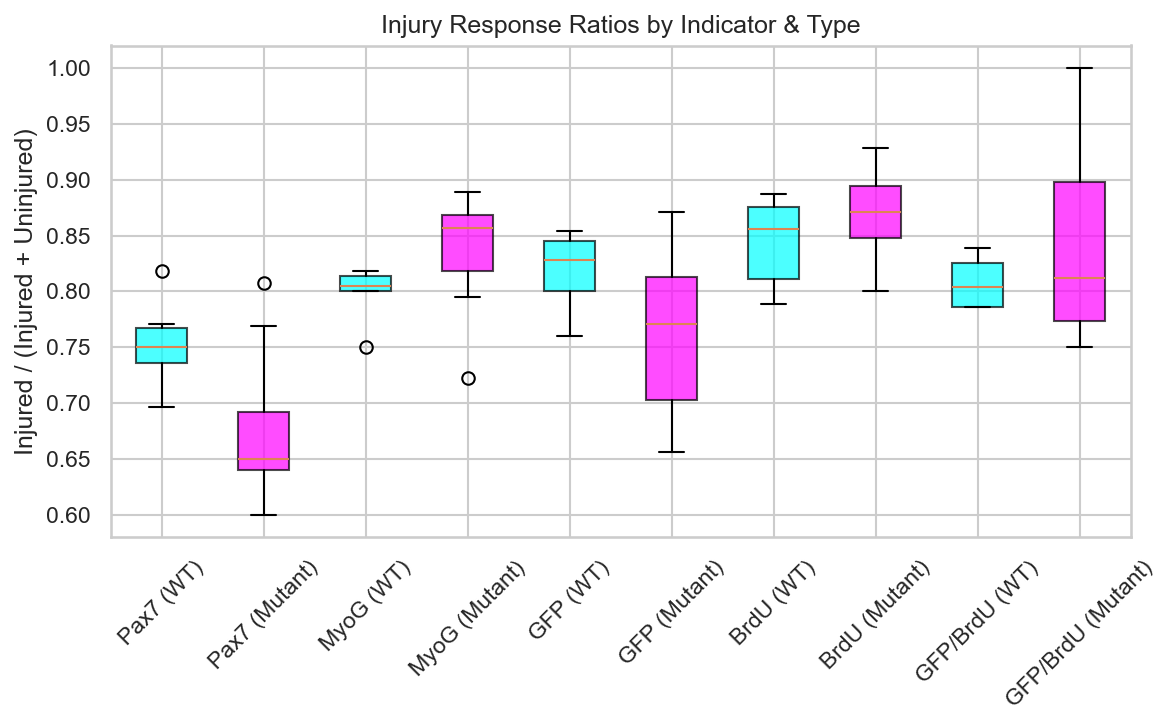

In [11]:
# ────────────────────────────────────────────────────────────
# Myotome Injury Response Analysis & Visualization
# ────────────────────────────────────────────────────────────

# 1. Load the myotome injury quantification data
myotome_data = pd.read_csv(marker_csv)

# 2. Compute summary metrics per Indicator and cell Type
def calculate_injury_metrics(df):
    """
    For each Indicator × Type, compute:
      - total injured/uninjured
      - injury_ratio = injured / (injured + uninjured)
      - injury_index = (injured − uninjured) / total
      - CV of injured and uninjured counts
    """
    rows = []
    for indicator in df["Indicator"].unique():
        for cell_type in df["Type"].unique():
            subset = df[(df.Indicator==indicator) & (df.Type==cell_type)]
            if subset.empty:
                continue
            injured   = subset["Injured"].sum()
            uninjured = subset["Uninjured"].sum()
            total     = injured + uninjured
            ratio     = injured / total if total>0 else np.nan
            index     = (injured - uninjured) / total if total>0 else np.nan
            injured_cv   = subset["Injured"].std()   / subset["Injured"].mean()   if subset["Injured"].mean()>0 else np.nan
            uninjured_cv = subset["Uninjured"].std() / subset["Uninjured"].mean() if subset["Uninjured"].mean()>0 else np.nan
            rows.append({
                "Indicator":      indicator,
                "Type":           cell_type,
                "total_injured":  injured,
                "total_uninjured":uninjured,
                "injury_ratio":   ratio,
                "injury_index":   index,
                "injured_cv":     injured_cv,
                "uninjured_cv":   uninjured_cv
            })
    return pd.DataFrame(rows)

myotome_metrics = calculate_injury_metrics(myotome_data)
export_df(myotome_metrics, "myotome_metrics")

# 3. Display the computed metrics
print("Myotome injury response metrics:")
display(myotome_metrics)

# 4. Statistical tests comparing WT vs MUT for each Indicator
test_rows = []
alpha      = 0.05
n_tests    = myotome_metrics["Indicator"].nunique()
alpha_corr = alpha / n_tests

for indicator in myotome_data["Indicator"].unique():
    wt = myotome_data[(myotome_data.Type=="WT") & (myotome_data.Indicator==indicator)]
    mut= myotome_data[(myotome_data.Type=="Mutant") & (myotome_data.Indicator==indicator)]
    if not wt.empty and not mut.empty:
        # compare injury ratios
        wt_ratio  = wt["Injured"] / (wt["Injured"]+wt["Uninjured"])
        mut_ratio = mut["Injured"]/(mut["Injured"]+mut["Uninjured"])
        u_stat, p_val = mannwhitneyu(wt_ratio, mut_ratio, alternative="two-sided")
        test_rows.append({
            "Indicator":    indicator,
            "WT_median":    np.median(wt_ratio),
            "MUT_median":   np.median(mut_ratio),
            "p_value":      p_val,
            "Significant":  p_val < alpha_corr
        })

injury_tests_df = pd.DataFrame(test_rows)
export_df(injury_tests_df, "myotome_statistical_tests")

# 5. Display test results
print(f"Myotome tests (Bonferroni α={alpha_corr:.4f}):")
display(injury_tests_df.sort_values("p_value"))

# 6. Visualize injury_ratio by Indicator and Type
fig, ax = plt.subplots(figsize=(8,5))
data_plot = []
labels    = []
colors    = []
for indicator in myotome_metrics["Indicator"].unique():
    for cell_type, col in [("WT","cyan"),("Mutant","magenta")]:
        vals = myotome_data[
            (myotome_data.Indicator==indicator) & (myotome_data.Type==cell_type)
        ]
        ratios = vals["Injured"]/(vals["Injured"]+vals["Uninjured"])
        data_plot.append(ratios)
        labels.append(f"{indicator} ({cell_type})")
        colors.append(col)

bp = ax.boxplot(data_plot, labels=labels, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title("Injury Response Ratios by Indicator & Type")
ax.set_ylabel("Injured / (Injured + Uninjured)")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
save_fig(fig, "injury_ratio_by_indicator_type")

In [12]:
# ────────────────────────────────────────────────────────────
# Compute and Export Sample‐Level Summary Metrics
# ────────────────────────────────────────────────────────────

def compute_sample_level_metrics(tracks_df, temporal_metrics):
    """
    For each imaging file (stack), compute:
      - number of tracks and detections
      - tracks per frame
      - summary statistics (mean, std, median, min, max) for key movement and shape metrics
      - sample‐level mean and std of each temporal metric
    """
    sample_rows = []
    # merge per‐track temporal metrics into the main tracks table
    merged = tracks_df.merge(
        temporal_metrics,
        on=["stack", "track_id", "Genotype"],
        how="left"
    )
    # identify metrics to aggregate
    basic_metrics = ["step_distance", "area", "eccentricity", "perimeter", "solidity"]
    temporal_cols = [c for c in temporal_metrics.columns if c not in ["stack","track_id","Genotype"]]
    
    # loop over each file
    for stack_name, grp in merged.groupby("stack"):
        genotype = grp["Genotype"].iloc[0]
        n_tracks    = grp["track_id"].nunique()
        n_detections = len(grp)
        n_frames     = grp["frame"].nunique()
        tracks_per_frame = n_detections / n_frames if n_frames>0 else np.nan
        
        row = {
            "source_file":       stack_name,
            "Genotype":          genotype,
            "n_tracks":          n_tracks,
            "n_detections":      n_detections,
            "tracks_per_frame":  tracks_per_frame
        }
        # aggregate basic metrics
        for metric in basic_metrics:
            vals = grp[metric].dropna()
            if len(vals)>0:
                row[f"{metric}_mean"]   = vals.mean()
                row[f"{metric}_std"]    = vals.std()
                row[f"{metric}_median"] = vals.median()
                row[f"{metric}_min"]    = vals.min()
                row[f"{metric}_max"]    = vals.max()
            else:
                for stat in ["mean","std","median","min","max"]:
                    row[f"{metric}_{stat}"] = np.nan
        # aggregate temporal metrics
        for metric in temporal_cols:
            vals = grp[metric].dropna()
            row[f"{metric}_sample_mean"] = vals.mean() if len(vals)>0 else np.nan
            row[f"{metric}_sample_std"]  = vals.std()  if len(vals)>0 else np.nan
        
        sample_rows.append(row)
    return pd.DataFrame(sample_rows)

# compute and export
sample_level_df = compute_sample_level_metrics(tracks_df, temporal_metrics)
export_df(sample_level_df, "sample_level_metrics")

# preview the first few samples
print(f"Computed sample‐level metrics for {len(sample_level_df)} files; preview:")
display(sample_level_df.head())

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\sample_level_metrics.csv
Computed sample‐level metrics for 16 files; preview:


,source_file,Genotype,n_tracks,n_detections,tracks_per_frame,step_distance_mean,step_distance_std,step_distance_median,step_distance_min,step_distance_max,...,late_eccentricity_mean_sample_mean,late_eccentricity_mean_sample_std,eccentricity_trend_slope_sample_mean,eccentricity_trend_slope_sample_std,temporal_persistence_sample_mean,temporal_persistence_sample_std,speed_cv_sample_mean,speed_cv_sample_std,directional_consistency_sample_mean,directional_consistency_sample_std
0,MUT-1.tif,MUT,375,3037,25.099174,15.611803,16.835698,8.666646,0.0,115.594242,...,0.874257,0.096769,-0.000577,0.026210,0.387989,0.315506,0.817440,0.268794,0.701526,0.087393
1,MUT-2.tif,MUT,337,1800,16.071429,11.512490,13.369046,4.574750,0.0,64.872761,...,0.894276,0.083691,0.001386,0.026574,0.324172,0.392368,0.824714,0.249304,0.712146,0.101453
2,MUT-3.tif,MUT,191,1104,16.984615,13.008981,14.113530,7.082039,0.0,81.518590,...,0.903876,0.087111,-0.000240,0.020561,0.327959,0.368797,0.769060,0.171437,0.714282,0.091398
3,MUT-5.tif,MUT,149,1082,23.521739,15.634439,20.981302,5.847779,0.0,137.743113,...,0.902920,0.101836,-0.001854,0.024912,0.361812,0.441046,0.847387,0.238538,0.698460,0.084103
4,MUT-6.tif,MUT,165,1086,23.608696,14.884002,15.672034,9.179216,0.0,76.236628,...,0.881451,0.088298,-0.000420,0.019391,0.208089,0.321784,0.740082,0.254857,0.693559,0.084971


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\sample_level_outliers.csv
Number of outlier metrics per sample:


,source_file,Genotype,n_outliers
7,WT-10.tif,WT,2
8,WT-2.tif,WT,2
10,WT-4.tif,WT,2
15,WT-9.tif,WT,2
3,MUT-5.tif,MUT,1
13,WT-7.tif,WT,1
0,MUT-1.tif,MUT,0
1,MUT-2.tif,MUT,0
2,MUT-3.tif,MUT,0
4,MUT-6.tif,MUT,0


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\sample_distribution_outliers.png


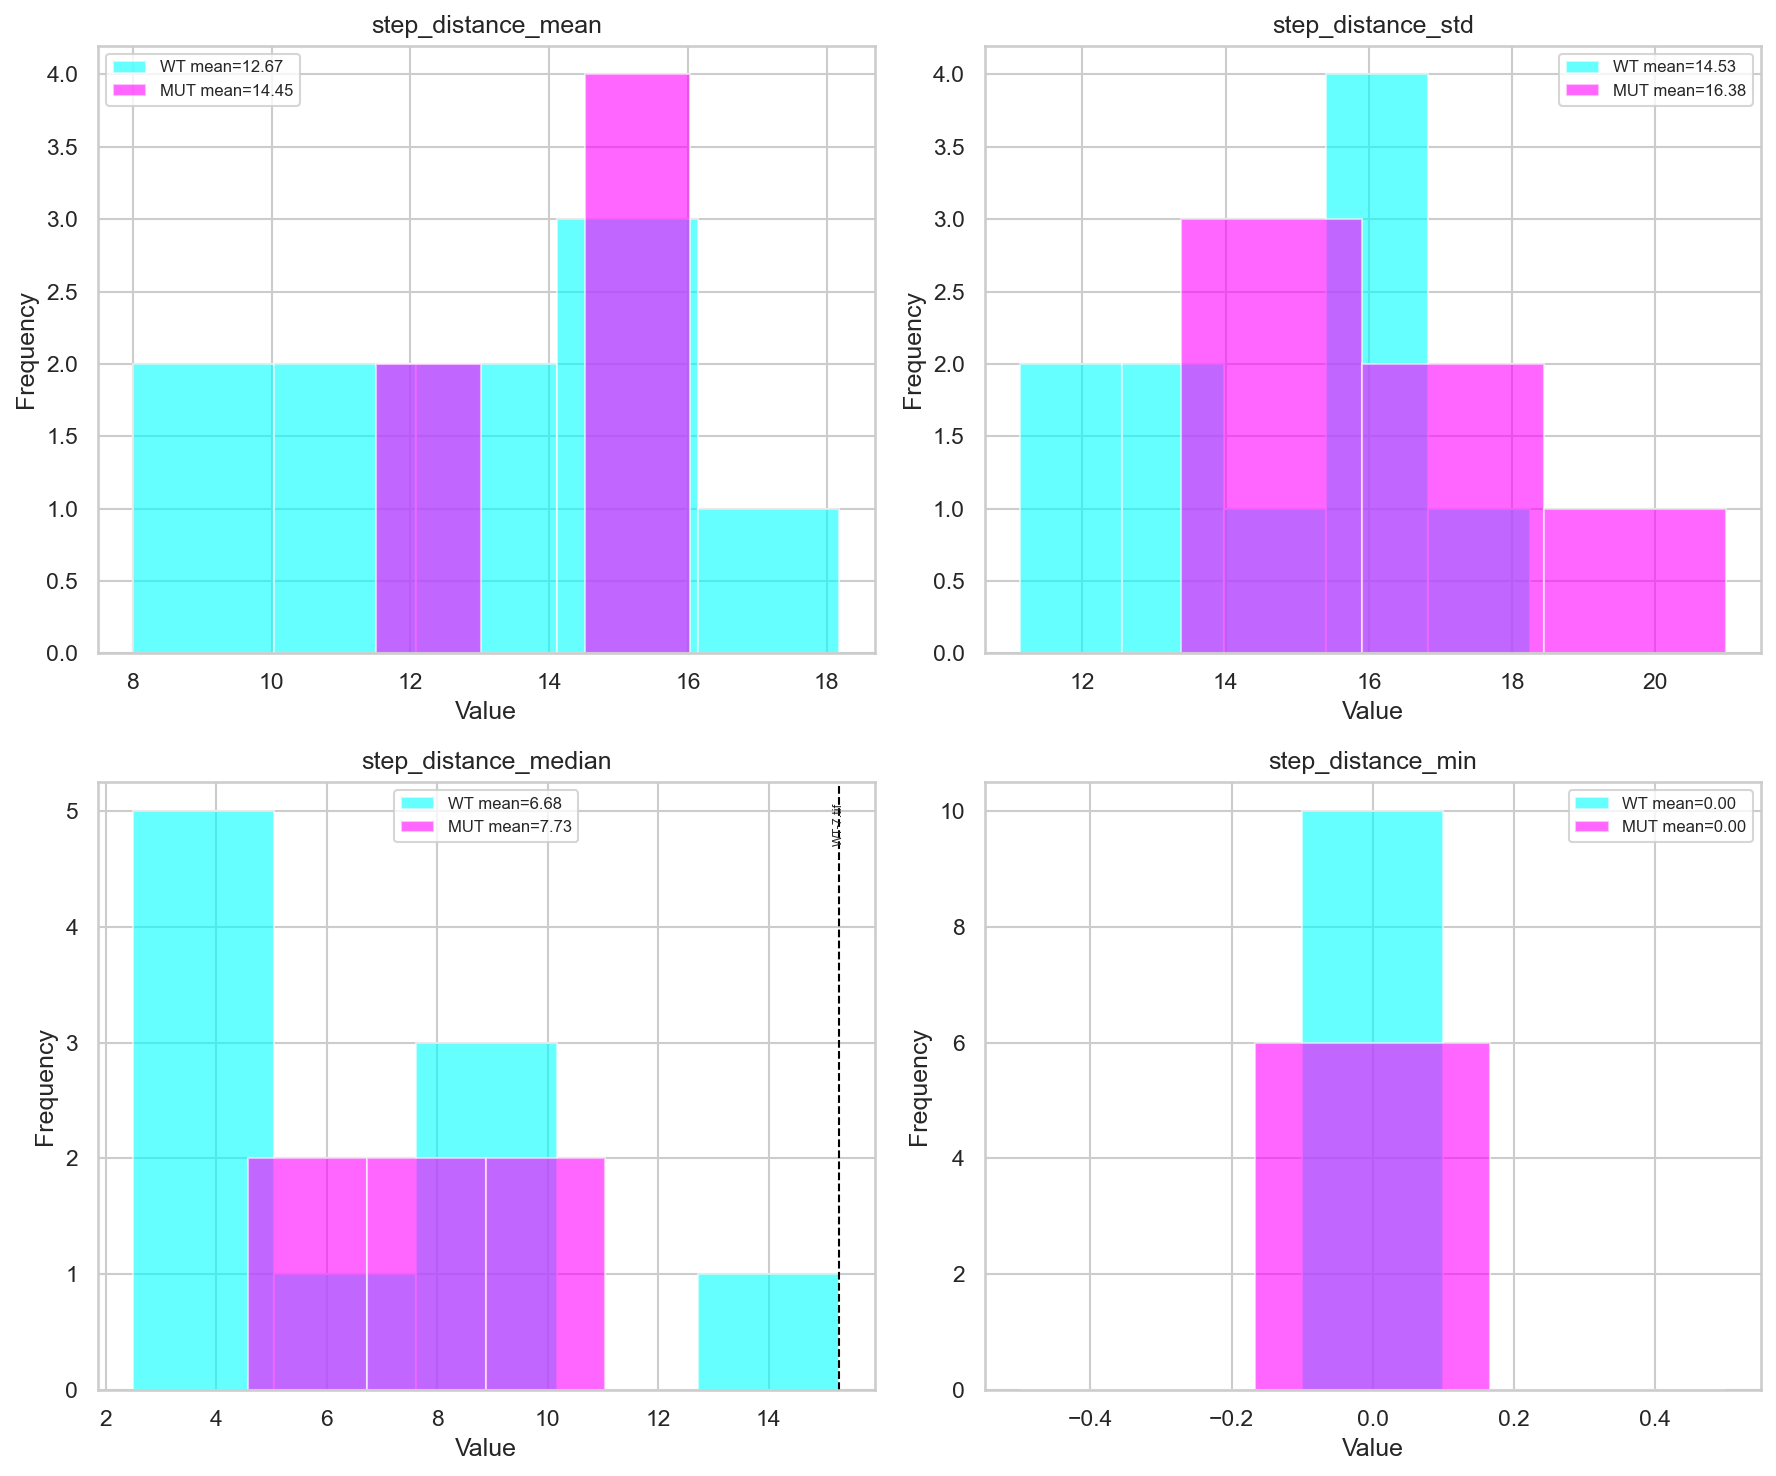

In [13]:
# ────────────────────────────────────────────────────────────
# Sample‐Level Outlier Detection and Distribution Analysis
# ────────────────────────────────────────────────────────────

# 1. Identify numeric metrics (exclude identifiers)
numeric_cols = sample_level_df.select_dtypes(include=[np.number]).columns.tolist()
meta_cols    = ["n_tracks", "n_detections", "tracks_per_frame"]
metric_cols  = [c for c in numeric_cols if c not in meta_cols]

# 2. Compute z‐scores within each genotype for each metric
outlier_rows = []
for metric in metric_cols:
    for geno in sample_level_df["Genotype"].unique():
        vals = sample_level_df.loc[sample_level_df.Genotype==geno, metric]
        if len(vals) < 2:
            continue
        mean_val = vals.mean()
        std_val  = vals.std()
        for _, row in sample_level_df[sample_level_df.Genotype==geno].iterrows():
            val = row[metric]
            if np.isnan(val):
                continue
            z = (val - mean_val) / std_val if std_val>0 else 0.0
            outlier_rows.append({
                "source_file":    row["source_file"],
                "Genotype":       geno,
                "metric":         metric,
                "value":          val,
                "geno_mean":      mean_val,
                "geno_std":       std_val,
                "z_score":        z,
                "is_outlier":     abs(z) > 2.0
            })

outlier_df = pd.DataFrame(outlier_rows)
export_df(outlier_df, "sample_level_outliers")

# 3. Summarize number of outliers per sample
outlier_summary = (
    outlier_df
    .groupby(["source_file","Genotype"])["is_outlier"]
    .sum()
    .reset_index()
    .rename(columns={"is_outlier":"n_outliers"})
)
print("Number of outlier metrics per sample:")
display(outlier_summary.sort_values("n_outliers", ascending=False))

# 4. Visualize distributions for the first four metrics
plot_metrics = metric_cols[:4]
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for ax, metric in zip(axes, plot_metrics):
    for geno, color in [("WT","cyan"),("MUT","magenta")]:
        vals = sample_level_df.loc[sample_level_df.Genotype==geno, metric].dropna()
        if len(vals)>0:
            ax.hist(vals, bins=max(3, len(vals)//2), alpha=0.6, label=f"{geno} mean={vals.mean():.2f}", color=color)
    # mark outliers
    for _, out in outlier_df[outlier_df.metric==metric].iterrows():
        if out["is_outlier"]:
            clr = "black"
            ax.axvline(out["value"], linestyle="--", linewidth=1, color=clr)
            ax.text(out["value"], ax.get_ylim()[1]*0.9, out["source_file"], rotation=90, fontsize=6, ha="center")
    ax.set_title(metric)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8)

plt.tight_layout()
save_fig(fig, "sample_distribution_outliers")

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\track_metrics_with_diffusion.csv
Diffusion columns available: ['alpha', 'K', 'D_est', 'P_est']


,track_id,Genotype,alpha,K,D_est,P_est
0,2815,MUT,-1.373909,377.142275,6.298123,8.938362e-08
1,2816,MUT,NaN,NaN,NaN,NaN
2,2817,MUT,0.138984,195.692103,9.821372,9.197617e-08
3,2818,MUT,0.459262,473.512298,59.203194,2.600034e-07
4,2819,MUT,1.638471,44.313095,52.589752,1.852368e+00


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\diffusion_parameter_tests.png


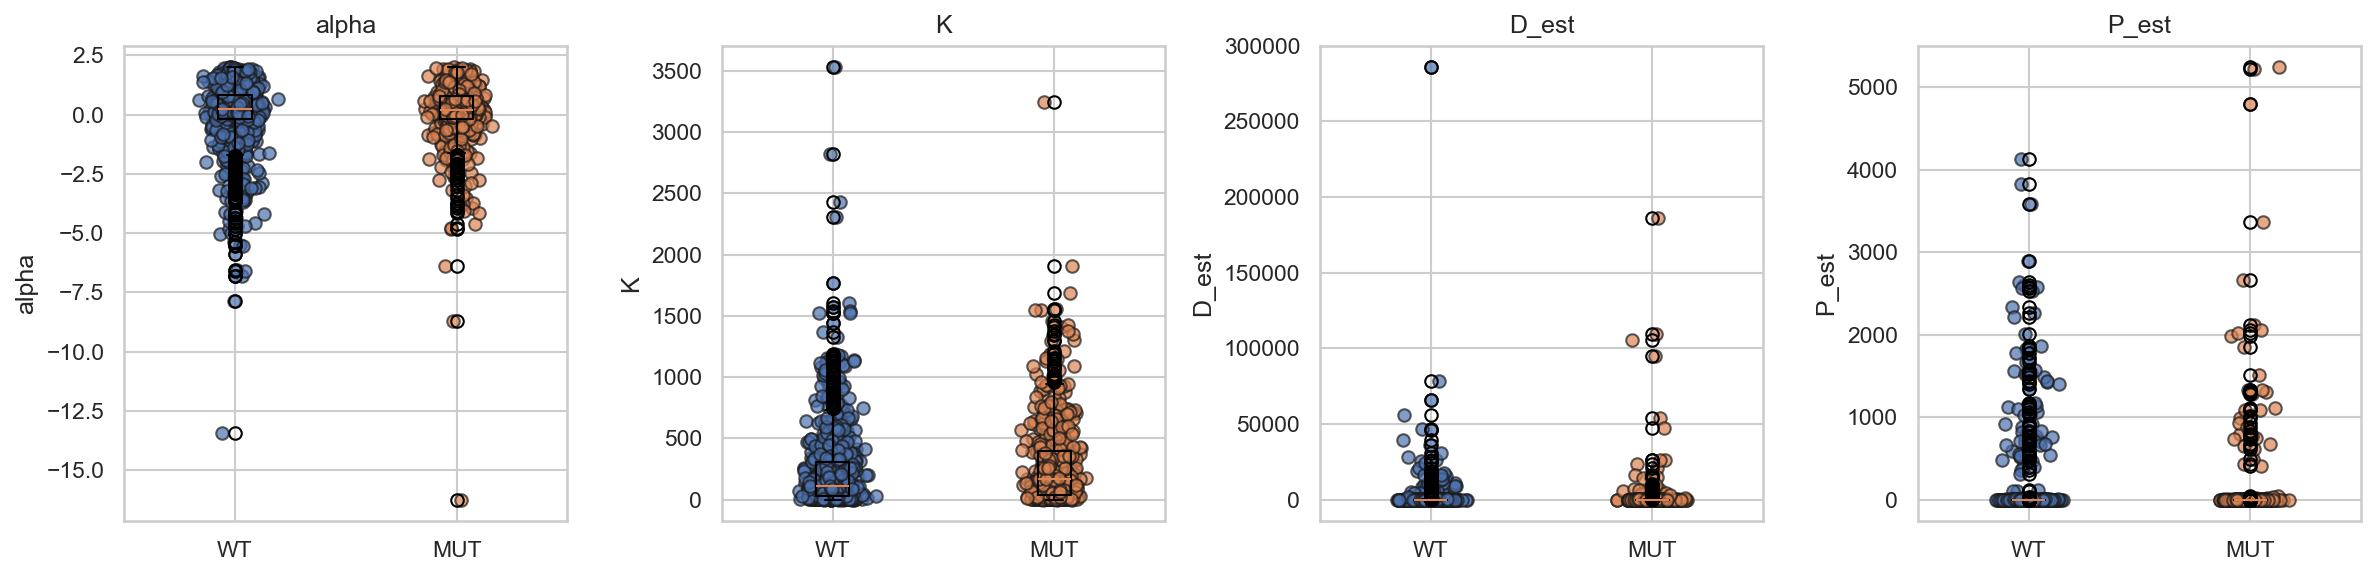

In [16]:
# ────────────────────────────────────────────────────────────
# Merge, Export, Preview & Visualize Diffusion Parameters
# ────────────────────────────────────────────────────────────

# Merge in the plaw_df and prw_df
track_metrics = (
    track_metrics
      .merge(plaw_df, on="track_id", how="left")
      .merge(prw_df,  on="track_id", how="left")
)

# Export the augmented table
export_df(track_metrics, "track_metrics_with_diffusion")

# 4Check which diffusion cols landed
diffusion_cols = [c for c in ["alpha","K","D_est","P_est"] if c in track_metrics.columns]
print("Diffusion columns available:", diffusion_cols)

# Preview the first few rows
display(track_metrics[["track_id","Genotype"] + diffusion_cols].head())

# Warn if anything is still missing
missing = set(["alpha","K","D_est","P_est"]) - set(diffusion_cols)
if missing:
    print(f" Warning: these expected columns are missing: {sorted(missing)}")

# Now visualize each one
if diffusion_cols:
    fig, axes = plt.subplots(1, len(diffusion_cols), figsize=(4 * len(diffusion_cols), 4))
    if len(diffusion_cols) == 1:
        axes = [axes]
    for ax, metric in zip(axes, diffusion_cols):
        wt = track_metrics.loc[track_metrics.Genotype == "WT",  metric].dropna()
        mu = track_metrics.loc[track_metrics.Genotype == "MUT", metric].dropna()
        ax.boxplot([wt, mu], labels=["WT","MUT"])
        ax.scatter(np.random.normal(1,0.05,len(wt)),  wt,  edgecolor="k", alpha=0.7)
        ax.scatter(np.random.normal(2,0.05,len(mu)), mu, edgecolor="k", alpha=0.7)
        ax.set_title(metric)
        ax.set_ylabel(metric)
    plt.tight_layout()
    save_fig(fig, "diffusion_parameter_tests")

Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\perimeter_time_series.png
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\shape_dynamics_per_track.csv
Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\perimeter_distribution.png


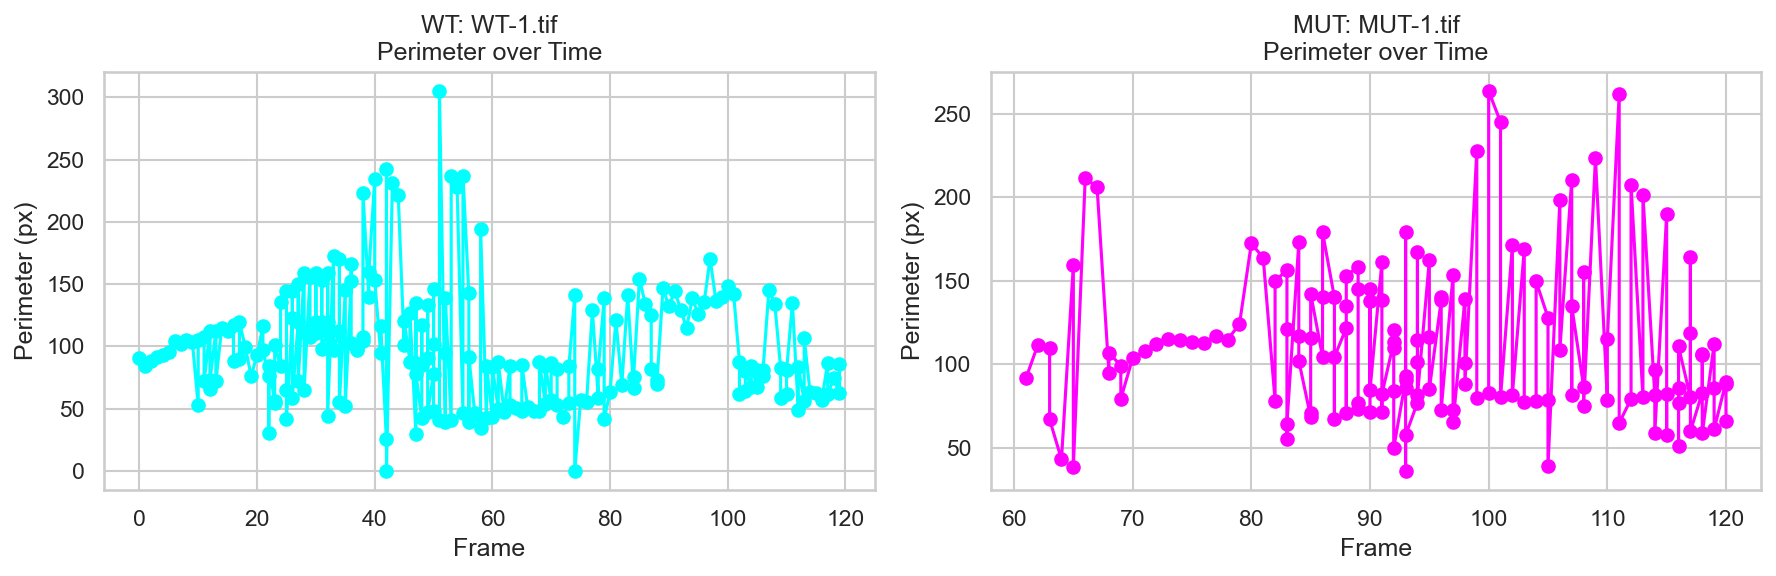

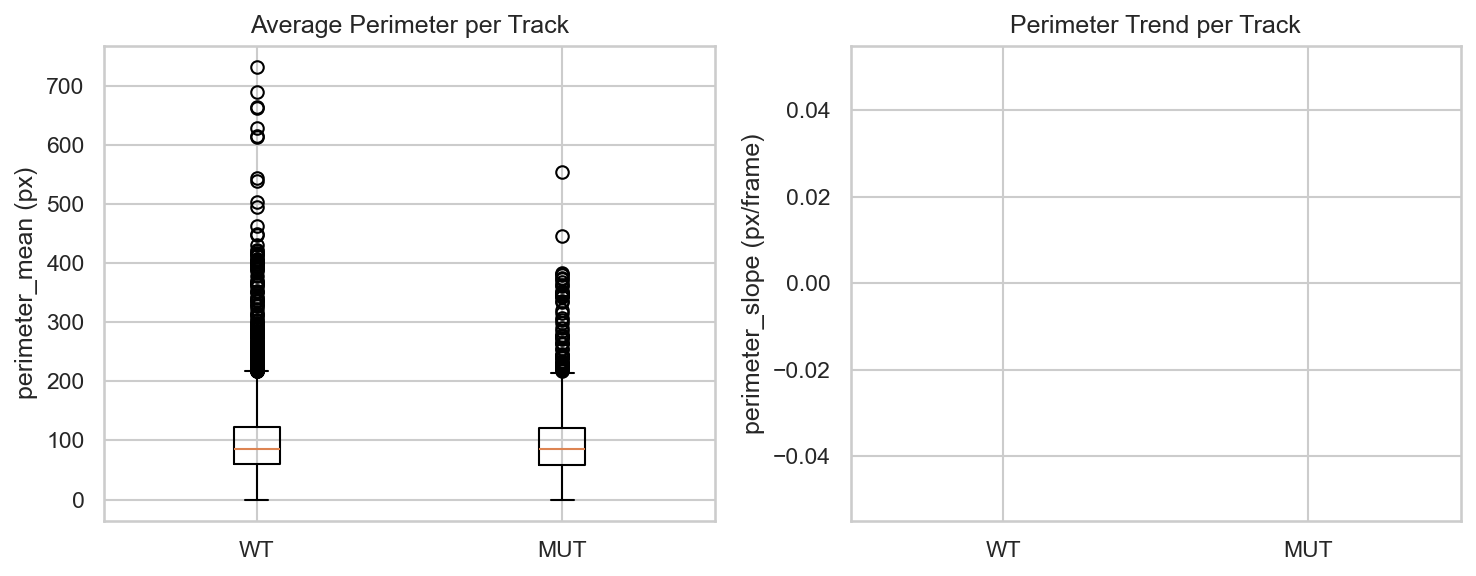

In [15]:
# ────────────────────────────────────────────────────────────
# Visualize Shape Dynamics – Perimeter (Time Series & Distribution)
# ────────────────────────────────────────────────────────────

# 1. Choose one representative file from each genotype
wt_file = wt_files[0]
mut_file = mut_files[0]
wt_base = os.path.basename(wt_file)
mut_base = os.path.basename(mut_file)

# 2. Within each file, pick the track with the most frames
wt_tracks = tracks_df[tracks_df['stack'] == wt_base]
mut_tracks = tracks_df[tracks_df['stack'] == mut_base]
wt_tid = wt_tracks['track_id'].value_counts().idxmax()
mut_tid = mut_tracks['track_id'].value_counts().idxmax()

# 3. Extract and sort those trajectories by frame
wt_traj = wt_tracks[wt_tracks['track_id'] == wt_tid].sort_values('frame')
mut_traj = mut_tracks[mut_tracks['track_id'] == mut_tid].sort_values('frame')

# 4. Plot perimeter vs. frame for each
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(wt_traj['frame'], wt_traj['perimeter'], '-o', color='cyan')
axes[0].set_title(f"WT: {wt_base}\nPerimeter over Time")
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Perimeter (px)")

axes[1].plot(mut_traj['frame'], mut_traj['perimeter'], '-o', color='magenta')
axes[1].set_title(f"MUT: {mut_base}\nPerimeter over Time")
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Perimeter (px)")

plt.tight_layout()
save_fig(fig, "perimeter_time_series")

# 5. Export the full per-track shape dynamics table for reference
export_df(shape_dynamics_df, "shape_dynamics_per_track")

# 6. Compare across all tracks: boxplots of perimeter_mean and perimeter_slope by genotype
wt_stats  = shape_dynamics_df[shape_dynamics_df['Genotype'] == "WT"]
mut_stats = shape_dynamics_df[shape_dynamics_df['Genotype'] == "MUT"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].boxplot([wt_stats['perimeter_mean'], mut_stats['perimeter_mean']], labels=['WT','MUT'])
axes[0].set_title("Average Perimeter per Track")
axes[0].set_ylabel("perimeter_mean (px)")

axes[1].boxplot([wt_stats['perimeter_slope'], mut_stats['perimeter_slope']], labels=['WT','MUT'])
axes[1].set_title("Perimeter Trend per Track")
axes[1].set_ylabel("perimeter_slope (px/frame)")

plt.tight_layout()
save_fig(fig, "perimeter_distribution")

Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\area_eccentricity_time_series.png
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\shape_dynamics_per_track.csv
Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\area_eccentricity_distribution.png


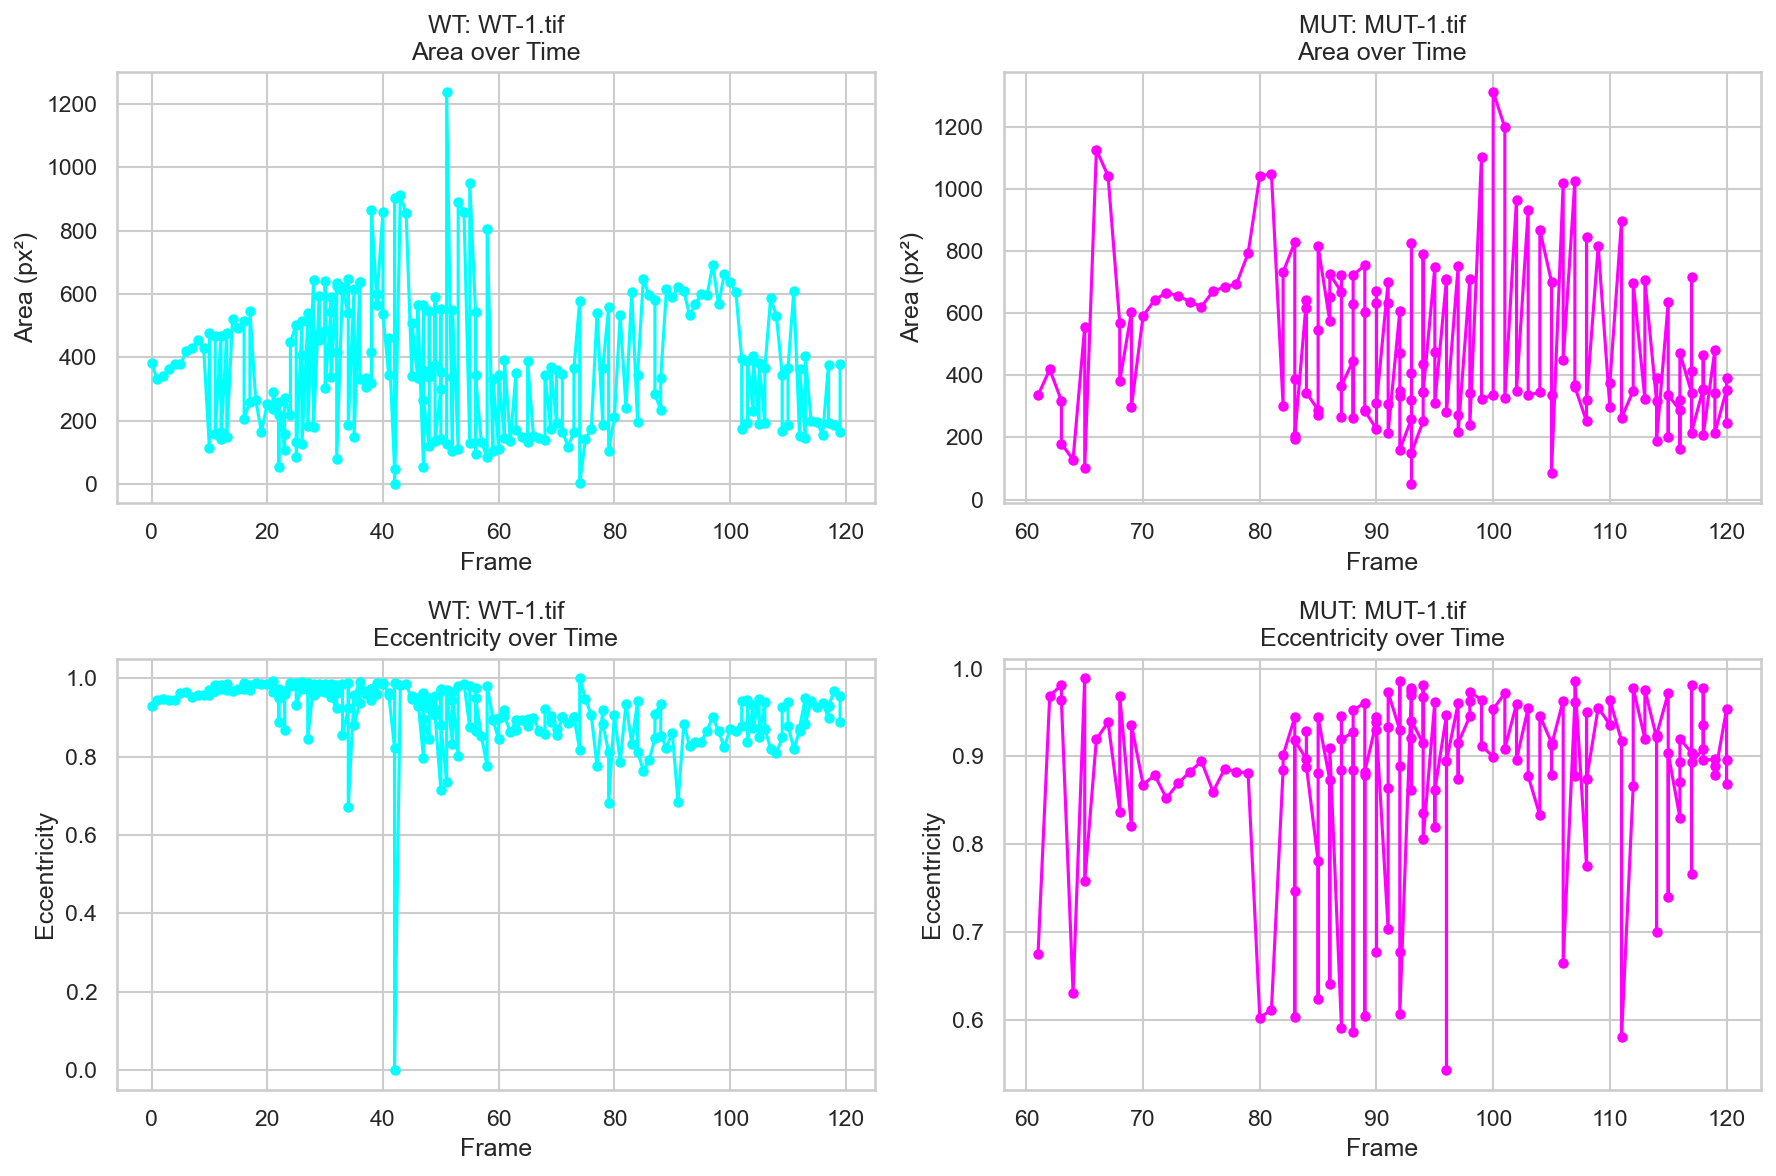

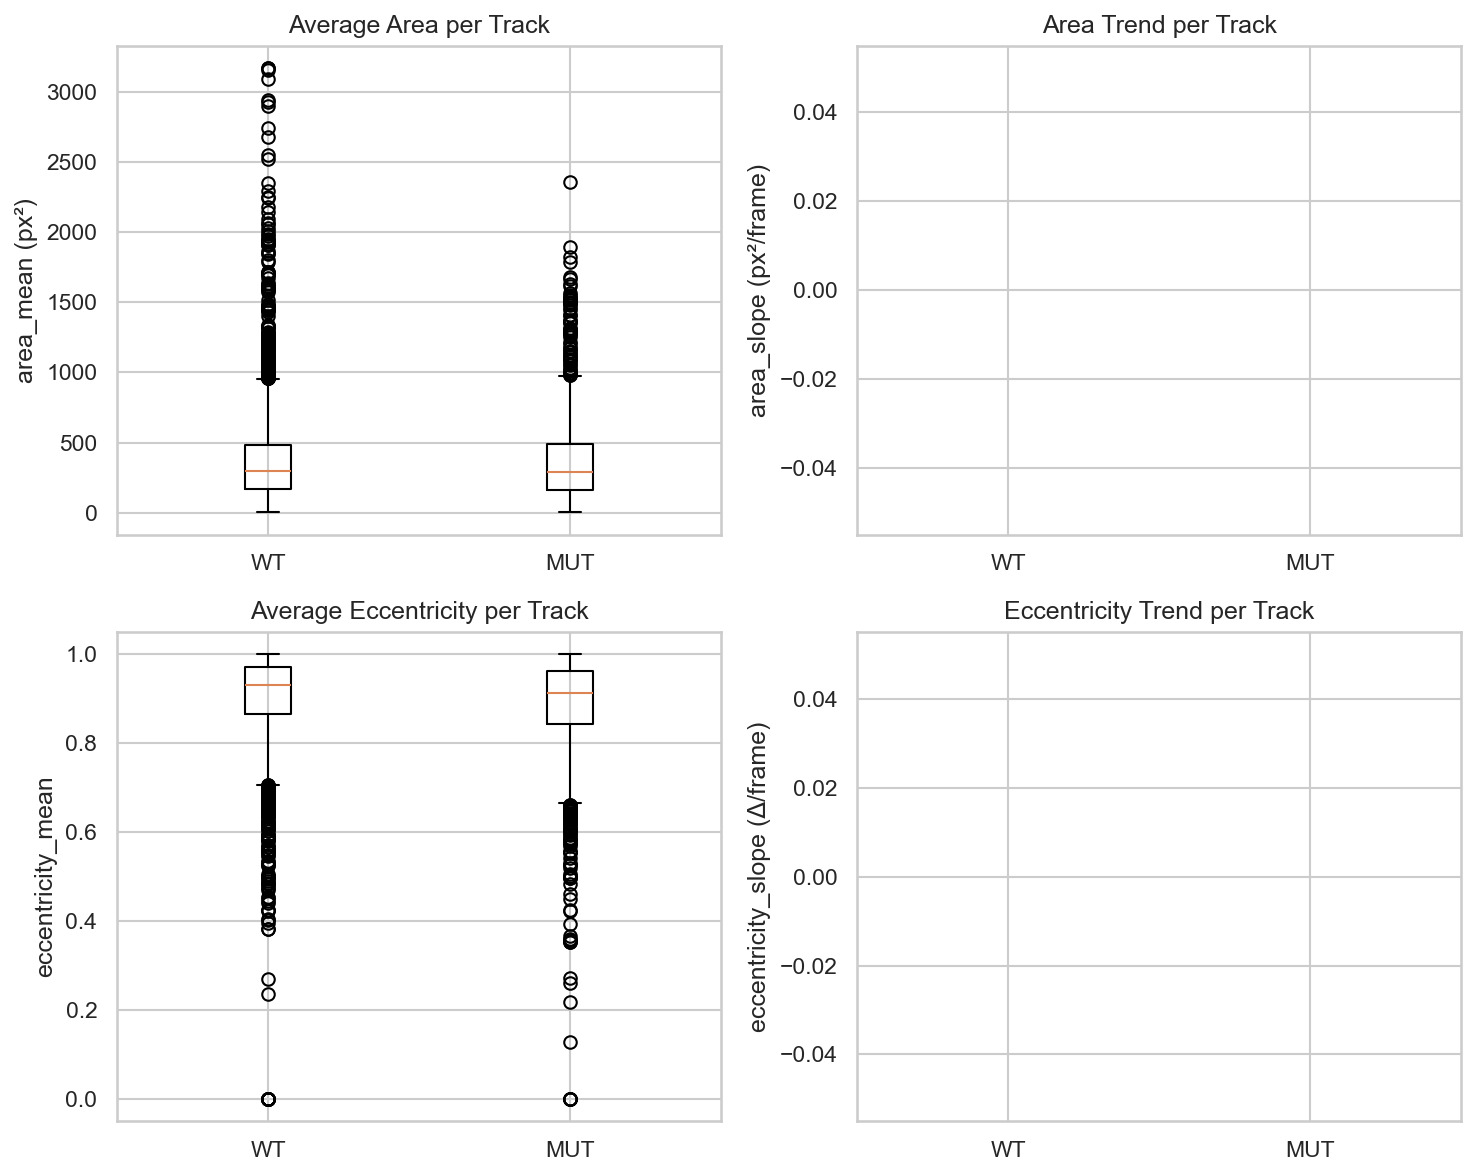

In [17]:
# ────────────────────────────────────────────────────────────
# Area & Eccentricity Dynamics for Representative Tracks
# and Population Distributions across All Tracks
# ────────────────────────────────────────────────────────────

# 1. Select one example file from each genotype
wt_file = wt_files[0]
mut_file = mut_files[0]
wt_name = os.path.basename(wt_file)
mut_name = os.path.basename(mut_file)

# 2. Within each file, find the track with the most frames
wt_sub  = tracks_df[tracks_df['stack'] == wt_name]
mut_sub = tracks_df[tracks_df['stack'] == mut_name]
wt_tid  = wt_sub['track_id'].value_counts().idxmax()
mut_tid = mut_sub['track_id'].value_counts().idxmax()

# 3. Extract and sort those trajectories by frame
wt_traj  = wt_sub[wt_sub['track_id'] == wt_tid].sort_values('frame')
mut_traj = mut_sub[mut_sub['track_id'] == mut_tid].sort_values('frame')

# 4. Plot Area and Eccentricity vs. Frame for each selected track
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# WT: Area over time
axes[0, 0].plot(wt_traj['frame'], wt_traj['area'], '-o', markersize=4, color='cyan')
axes[0, 0].set_title(f"WT: {wt_name}\nArea over Time")
axes[0, 0].set_xlabel("Frame")
axes[0, 0].set_ylabel("Area (px²)")

# WT: Eccentricity over time
axes[1, 0].plot(wt_traj['frame'], wt_traj['eccentricity'], '-o', markersize=4, color='cyan')
axes[1, 0].set_title(f"WT: {wt_name}\nEccentricity over Time")
axes[1, 0].set_xlabel("Frame")
axes[1, 0].set_ylabel("Eccentricity")

# MUT: Area over time
axes[0, 1].plot(mut_traj['frame'], mut_traj['area'], '-o', markersize=4, color='magenta')
axes[0, 1].set_title(f"MUT: {mut_name}\nArea over Time")
axes[0, 1].set_xlabel("Frame")
axes[0, 1].set_ylabel("Area (px²)")

# MUT: Eccentricity over time
axes[1, 1].plot(mut_traj['frame'], mut_traj['eccentricity'], '-o', markersize=4, color='magenta')
axes[1, 1].set_title(f"MUT: {mut_name}\nEccentricity over Time")
axes[1, 1].set_xlabel("Frame")
axes[1, 1].set_ylabel("Eccentricity")

plt.tight_layout()
save_fig(fig, "area_eccentricity_time_series")

# 5. Export the per-track shape dynamics DataFrame for reference
export_df(shape_dynamics_df, "shape_dynamics_per_track")

# 6. Compare distributions across all tracks: mean and slope for area & eccentricity
wt_stats  = shape_dynamics_df[shape_dynamics_df['Genotype'] == 'WT']
mut_stats = shape_dynamics_df[shape_dynamics_df['Genotype'] == 'MUT']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Average Area per track
axes[0, 0].boxplot(
    [wt_stats['area_mean'], mut_stats['area_mean']],
    labels=['WT','MUT']
)
axes[0, 0].set_title("Average Area per Track")
axes[0, 0].set_ylabel("area_mean (px²)")

# Area slope per track
axes[0, 1].boxplot(
    [wt_stats['area_slope'], mut_stats['area_slope']],
    labels=['WT','MUT']
)
axes[0, 1].set_title("Area Trend per Track")
axes[0, 1].set_ylabel("area_slope (px²/frame)")

# Average Eccentricity per track
axes[1, 0].boxplot(
    [wt_stats['eccentricity_mean'], mut_stats['eccentricity_mean']],
    labels=['WT','MUT']
)
axes[1, 0].set_title("Average Eccentricity per Track")
axes[1, 0].set_ylabel("eccentricity_mean")

# Eccentricity slope per track
axes[1, 1].boxplot(
    [wt_stats['eccentricity_slope'], mut_stats['eccentricity_slope']],
    labels=['WT','MUT']
)
axes[1, 1].set_title("Eccentricity Trend per Track")
axes[1, 1].set_ylabel("eccentricity_slope (Δ/frame)")

plt.tight_layout()
save_fig(fig, "area_eccentricity_distribution")


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\diffusion_tests.csv
Mann–Whitney U tests on diffusion parameters (Bonferroni α = 0.013):


,Metric,WT_Median,MUT_Median,U_statistic,p_value,Significant
0,alpha,2.233778e-01,1.977025e-01,363769.0,0.425789,No
1,K,1.140748e+02,1.661941e+02,313134.0,0.000032,Yes
2,D_est,1.354991e+01,1.700947e+01,324997.0,0.002742,Yes
3,P_est,1.786202e-07,1.604690e-07,367092.0,0.262117,No


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\diffusion_parameter_tests.png


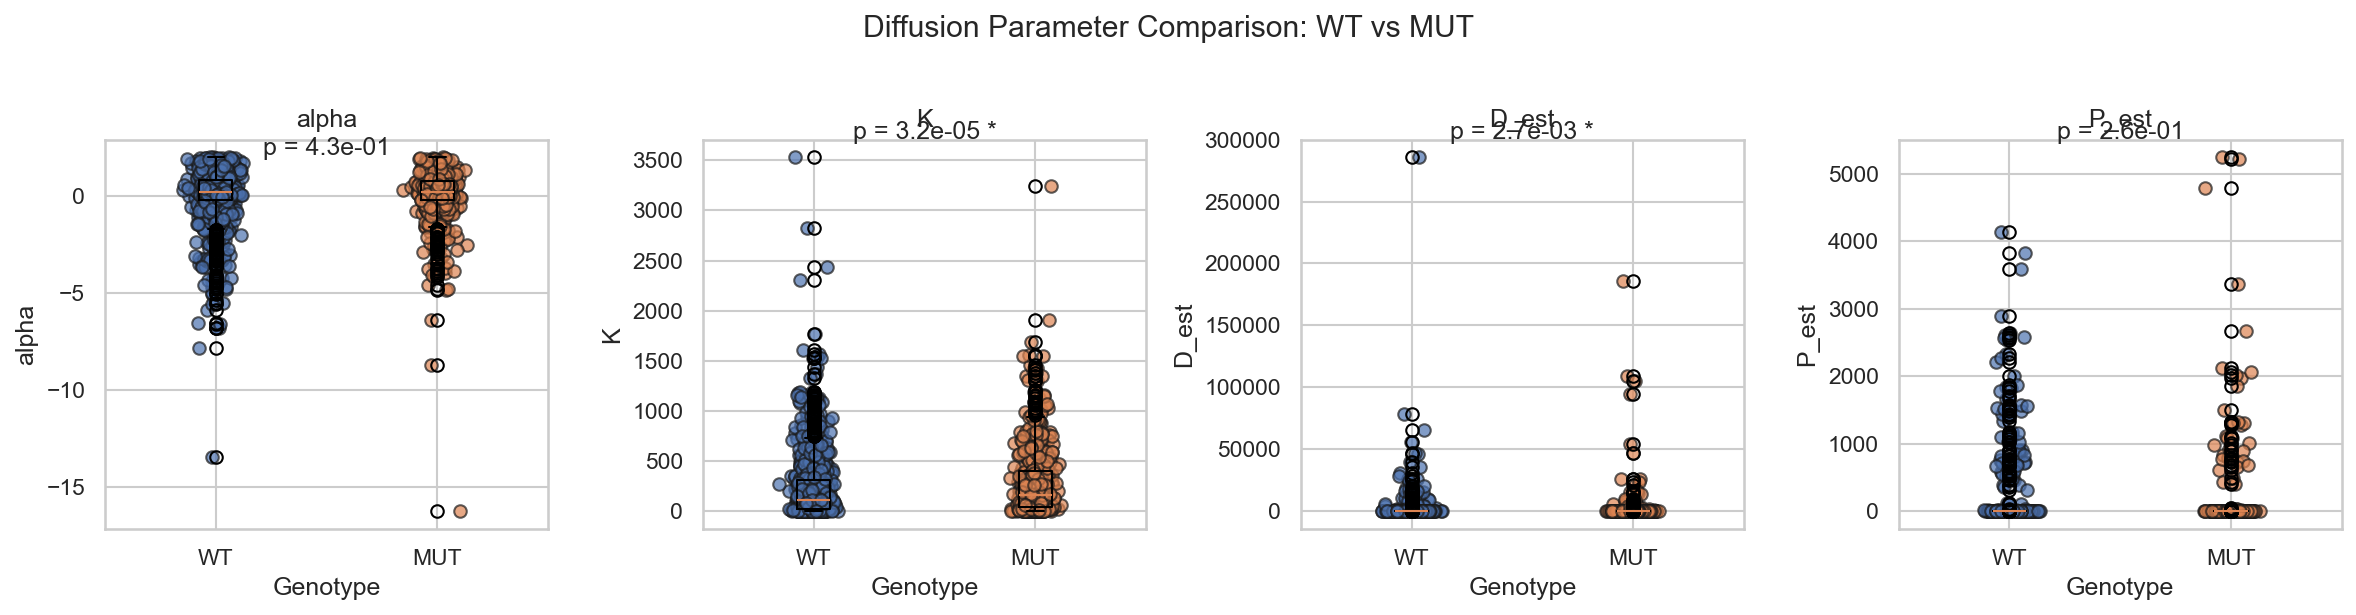

In [18]:
# ────────────────────────────────────────────────────────────
# Statistical Tests on Diffusion Parameters
# ────────────────────────────────────────────────────────────

# 1. Detect which diffusion metrics are present
_candidate = ["alpha", "K", "D_est", "P_est"]
diffusion_metrics = [m for m in _candidate if m in track_metrics.columns]

if not diffusion_metrics:
    print("No diffusion metrics found in `track_metrics`. Skipping diffusion‐parameter tests.")
else:
    # 2. Prepare results container and Bonferroni correction
    alpha_corr = 0.05 / len(diffusion_metrics)
    test_rows = []

    # 3. Run Mann–Whitney U for each metric
    for metric in diffusion_metrics:
        wt_vals  = track_metrics.loc[track_metrics.Genotype == "WT",  metric].dropna()
        mut_vals = track_metrics.loc[track_metrics.Genotype == "MUT", metric].dropna()
        if len(wt_vals) > 0 and len(mut_vals) > 0:
            u_stat, p_val = mannwhitneyu(wt_vals, mut_vals, alternative="two-sided")
            test_rows.append({
                "Metric":       metric,
                "WT_Median":    wt_vals.median(),
                "MUT_Median":   mut_vals.median(),
                "U_statistic":  u_stat,
                "p_value":      p_val,
                "Significant":  "Yes" if p_val < alpha_corr else "No"
            })

    # 4. Build DataFrame, export and display
    diffusion_tests_df = pd.DataFrame(test_rows)
    export_df(diffusion_tests_df, "diffusion_tests")

    print(f"Mann–Whitney U tests on diffusion parameters (Bonferroni α = {alpha_corr:.3f}):")
    display(diffusion_tests_df)

    # 5. Visualize each with boxplots + jitter
    fig, axes = plt.subplots(1, len(diffusion_metrics), figsize=(4 * len(diffusion_metrics), 4))
    if len(diffusion_metrics) == 1:
        axes = [axes]

    for ax, metric in zip(axes, diffusion_metrics):
        wt_vals  = track_metrics.loc[track_metrics.Genotype == "WT",  metric].dropna()
        mut_vals = track_metrics.loc[track_metrics.Genotype == "MUT", metric].dropna()

        # draw boxplot
        ax.boxplot([wt_vals, mut_vals], labels=["WT", "MUT"])

        # overlay jittered points
        x_wt  = np.random.normal(1, 0.04, size=len(wt_vals))
        x_mut = np.random.normal(2, 0.04, size=len(mut_vals))
        ax.scatter(x_wt,  wt_vals,  edgecolor="k", alpha=0.7)
        ax.scatter(x_mut, mut_vals, edgecolor="k", alpha=0.7)

        # annotate p-value
        row = diffusion_tests_df.query("Metric == @metric").iloc[0]
        p   = row["p_value"]
        star= " *" if row["Significant"] == "Yes" else ""
        ymax= max(wt_vals.max() if len(wt_vals)>0 else 0,
                  mut_vals.max() if len(mut_vals)>0 else 0)
        ax.text(1.5, ymax * 1.05, f"p = {p:.1e}{star}", ha="center")

        ax.set_title(metric)
        ax.set_xlabel("Genotype")
        ax.set_ylabel(metric)

    plt.suptitle("Diffusion Parameter Comparison: WT vs MUT", y=1.02)
    plt.tight_layout()
    save_fig(fig, "diffusion_parameter_tests")

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\pf_sdf_tests.csv
Mann–Whitney U tests on PF-SDF summaries (Bonferroni α = 0.017):


,Metric,WT_Median,MUT_Median,U_statistic,p_value,Significant
0,r_peak,3.000000,3.000000,30.0,1.000000,No
1,g_peak,49881.904431,44215.943875,33.0,0.792458,No
2,corr_length,9.000000,9.000000,27.0,0.763856,No


Saved figure: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\pf_sdf_summary_tests.png


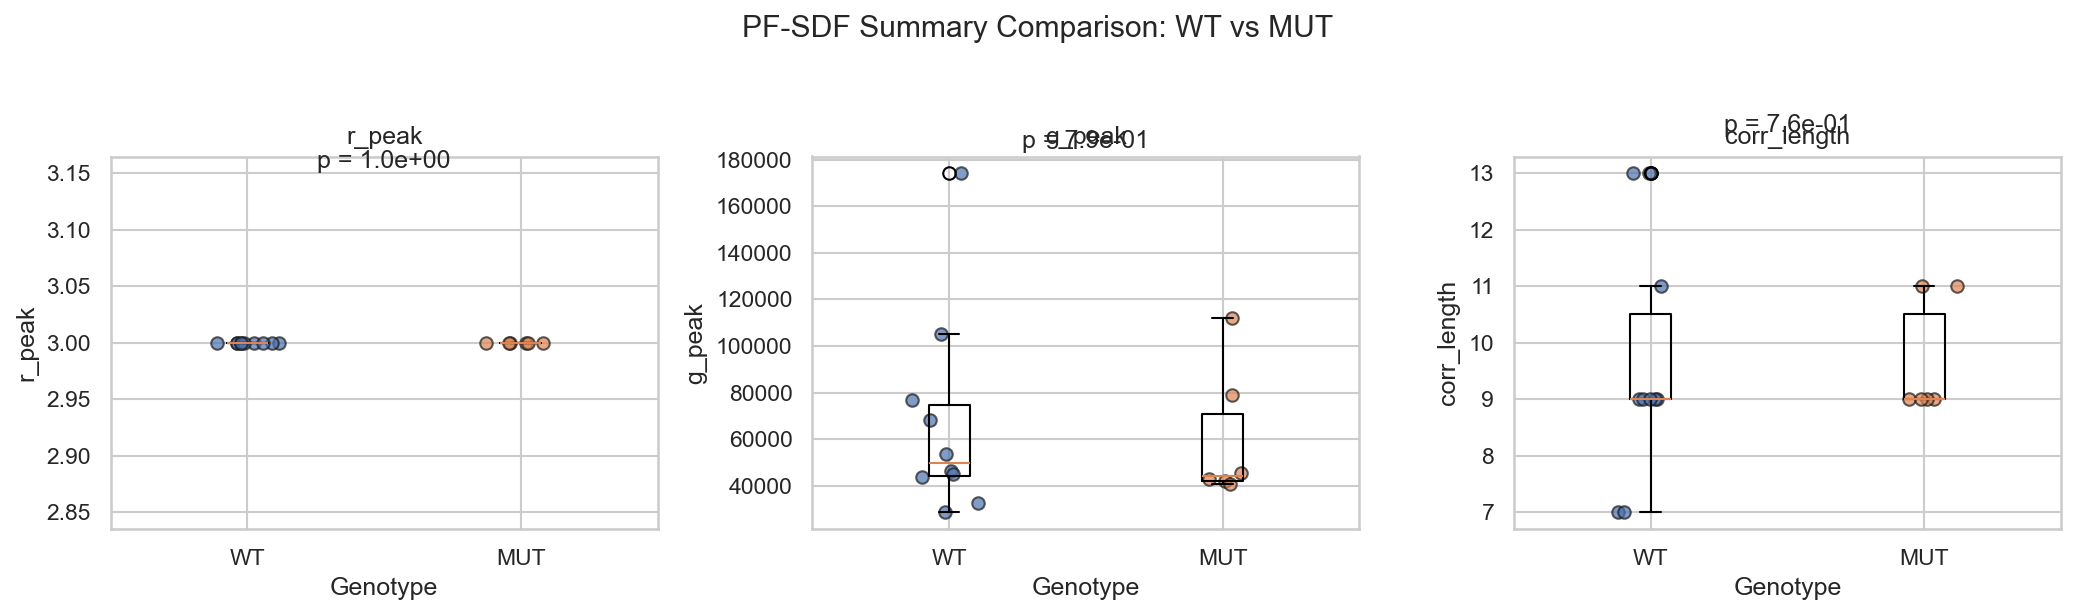

In [19]:
# ────────────────────────────────────────────────────────────
# Statistical Tests on PF-SDF Summaries
# ────────────────────────────────────────────────────────────

# 1. Define which PF-SDF metrics to test
pf_metrics = ["r_peak", "g_peak", "corr_length"]

# 2. Prepare results container
pf_test_rows = []
alpha_corr = 0.05 / len(pf_metrics)

for metric in pf_metrics:
    # collect values by genotype
    wt_vals  = pc_df.loc[pc_df.Genotype == "WT",  metric].dropna()
    mut_vals = pc_df.loc[pc_df.Genotype == "MUT", metric].dropna()
    
    # only test if both groups have data
    if len(wt_vals) > 0 and len(mut_vals) > 0:
        u_stat, p_val = mannwhitneyu(wt_vals, mut_vals, alternative="two-sided")
        pf_test_rows.append({
            "Metric":        metric,
            "WT_Median":     wt_vals.median(),
            "MUT_Median":    mut_vals.median(),
            "U_statistic":   u_stat,
            "p_value":       p_val,
            "Significant":   "Yes" if p_val < alpha_corr else "No"
        })

# 3. Build DataFrame and export
pf_sdf_tests_df = pd.DataFrame(pf_test_rows)
export_df(pf_sdf_tests_df, "pf_sdf_tests")

print(f"Mann–Whitney U tests on PF-SDF summaries (Bonferroni α = {alpha_corr:.3f}):")
display(pf_sdf_tests_df)

# 4. Visualize with boxplots and jittered points
fig, axes = plt.subplots(1, len(pf_metrics), figsize=(14, 4))
fig.subplots_adjust(wspace=0.4)

for ax, metric in zip(axes, pf_metrics):
    wt_vals  = pc_df.loc[pc_df.Genotype == "WT",  metric].dropna()
    mut_vals = pc_df.loc[pc_df.Genotype == "MUT", metric].dropna()
    
    # boxplot
    ax.boxplot([wt_vals, mut_vals], labels=["WT","MUT"])
    
    # jittered points
    x_wt  = np.random.normal(1, 0.05, size=len(wt_vals))
    x_mut = np.random.normal(2, 0.05, size=len(mut_vals))
    ax.scatter(x_wt,  wt_vals,  edgecolor="k", alpha=0.7)
    ax.scatter(x_mut, mut_vals, edgecolor="k", alpha=0.7)
    
    # annotate p-value
    row = pf_sdf_tests_df.loc[pf_sdf_tests_df.Metric == metric].iloc[0]
    p   = row["p_value"]
    star= " *" if row["Significant"] == "Yes" else ""
    ymax= max(wt_vals.max(), mut_vals.max()) if len(wt_vals)>0 and len(mut_vals)>0 else 1
    ax.text(1.5, ymax*1.05, f"p = {p:.1e}{star}", ha="center", va="bottom")
    
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("Genotype")

plt.suptitle("PF-SDF Summary Comparison: WT vs MUT", y=1.02)
plt.tight_layout()
save_fig(fig, "pf_sdf_summary_tests")

In [20]:
# ────────────────────────────────────────────────────────────
# Consolidate Per-Track Feature Table
# ────────────────────────────────────────────────────────────

# 1. Start with the core track_metrics (motility + diffusion)
per_track_features = track_metrics.copy()

# 2. Merge in per-track shape dynamics
#    (means, deltas, slopes for area, perimeter, ecc, solidity, orientation)
per_track_features = per_track_features.merge(
    shape_dynamics_df,
    on=['stack', 'track_id', 'Genotype'],
    how='left'
)

# 3. Merge in temporal metrics
#    (early/late speeds, trends, volatility, persistence, etc.)
per_track_features = per_track_features.merge(
    temporal_metrics,
    on=['stack', 'track_id', 'Genotype'],
    how='left'
)

# 4. Merge in PF-SDF summaries by stack (per-file)
#    we only need the summary columns, not the full r_vals/g_vals arrays
pf_summary = (
    pc_df[['source_file', 'r_peak', 'g_peak', 'corr_length']]
    .rename(columns={'source_file': 'stack'})
)
per_track_features = per_track_features.merge(
    pf_summary,
    on='stack',
    how='left'
)

# 5. Export the consolidated per-track feature table
export_df(per_track_features, "per_track_features")

# 6. Quick sanity check
print(f"Per-track feature table: {per_track_features.shape[0]} rows × {per_track_features.shape[1]} columns")
display(per_track_features.head())

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\per_track_features.csv
Per-track feature table: 4263 rows × 60 columns


,stack,track_id,Genotype,num_frames,total_path_length,net_displacement,directionality_ratio,mean_speed,max_speed,n_stationary,...,area_volatility,early_eccentricity_mean,late_eccentricity_mean,eccentricity_trend_slope,temporal_persistence,speed_cv,directional_consistency,r_peak,g_peak,corr_length
0,MUT-1.tif,2815,MUT,7.0,54.262985,4.420743,0.081469,7.751855,23.970868,1.0,...,0.302955,0.952431,0.959165,-0.004451,0.313032,1.325220,0.587668,3.0,112054.157935,9.0
1,MUT-1.tif,2816,MUT,1.0,0.000000,0.000000,NaN,0.000000,0.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,112054.157935,9.0
2,MUT-1.tif,2817,MUT,15.0,109.755676,29.340924,0.267329,7.317045,32.211210,1.0,...,0.214857,0.920466,0.895490,-0.003546,0.354861,1.472150,0.633272,3.0,112054.157935,9.0
3,MUT-1.tif,2818,MUT,7.0,131.329183,37.026664,0.281938,18.761312,38.198791,1.0,...,0.642569,0.974143,0.963114,0.003428,0.297940,0.694317,0.665681,3.0,112054.157935,9.0
4,MUT-1.tif,2819,MUT,12.0,61.593071,39.352121,0.638905,5.132756,11.909970,1.0,...,0.236859,0.984283,0.950192,-0.004584,0.314311,0.666360,0.611050,3.0,112054.157935,9.0


In [21]:
# ────────────────────────────────────────────────────
# Define Domain-Specific Feature Lists for Modeling
# ────────────────────────────────────────────────────

# 1. List of all candidate feature columns (drop identifiers)
feature_cols = [c for c in per_track_features.columns 
                if c not in ("track_id", "stack", "Genotype")]

# 2. Core motility & simple shape (original) features
original_features = [
    "num_frames", "total_path_length", "net_displacement",
    "directionality_ratio", "mean_speed", "max_speed",
    "n_stationary", "persistence_fraction"
]

# 3. Diffusion parameters (power-law & PRW)
diffusion_features = [c for c in feature_cols 
                      if c.startswith(("alpha", "K", "D_est", "P_est"))]

# 4. Shape-dynamics summary (means, deltas, slopes for area/perimeter/etc.)
shape_features = [c for c in feature_cols 
                  if any(c.startswith(pref) for pref in 
                         ("area_", "perimeter_", "eccentricity_", "solidity_", "orientation_"))
                  and not any(kw in c for kw in ("early_", "late_", "trend", "volatility", "cv", "directional"))]

# 5. Temporal-dynamics features
temporal_features = [c for c in feature_cols 
                     if any(kw in c for kw in 
                            ("early_", "late_", "trend", "acceleration", 
                             "volatility", "cv", "persistence", "directional"))]

# 6. PF-SDF spatial-clustering summaries
pf_sdf_features = [c for c in feature_cols 
                   if c in ("r_peak", "g_peak", "corr_length")]

# 7. Myotome injury–response features (empty cause per-track details not available)
myotome_features_list = [c for c in feature_cols 
                         if any(c.lower().startswith(pref) for pref in 
                                ("pax7", "myog", "brdu", "gfp", "injury"))]

# 8. Quick sanity check
print(f"Total feature columns:       {len(feature_cols)}")
print(f"Original features:           {len(original_features)}")
print(f"Diffusion features:          {len(diffusion_features)}")
print(f"Shape features:              {len(shape_features)}")
print(f"Temporal features:           {len(temporal_features)}")
print(f"PF-SDF features:             {len(pf_sdf_features)}")
print(f"Myotome features:            {len(myotome_features_list)}")

Total feature columns:       57
Original features:           8
Diffusion features:          12
Shape features:              20
Temporal features:           16
PF-SDF features:             3
Myotome features:            0


In [22]:
# ────────────────────────────────────────────────────────────
# Progressive Modeling & Feature‐Set Comparison
# ────────────────────────────────────────────────────────────

# 1. Base feature‐matrix, label vector, and file‐group vector
X_df       = per_track_features.copy()
feature_cols = [
    c for c in X_df.columns
    if c not in ("track_id", "stack", "Genotype")
    and np.issubdtype(X_df[c].dtype, np.number)
]
y_full     = (X_df["Genotype"] == "MUT").astype(int).values
groups_full = X_df["stack"].values

# 2. Collect domain‐specific lists (must have been defined earlier)
temporal_features     = globals().get("temporal_features", [])
diffusion_features    = globals().get("diffusion_features", [])
pf_sdf_features       = globals().get("pf_sdf_features", [])
myotome_features_list = globals().get("myotome_features_list", [])

# 3. Derive original_features by excluding the “extra” domains
excluded = set(temporal_features + diffusion_features + pf_sdf_features + myotome_features_list)
original_features = [c for c in feature_cols if c not in excluded]

# 4. Progressive feature‐set definitions
feature_sets = {
    "Original":               original_features,
    "Original + Temporal":    original_features + temporal_features,
    "Original + Diffusion":   original_features + diffusion_features,
    "Original + PF-SDF":      original_features + pf_sdf_features,
    "Original + Injury":      original_features + myotome_features_list,
    "All Features":           feature_cols
}

# 5. Models and CV objects
models = {
    "LogisticRegression": Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegressionCV(cv=3, max_iter=1000, random_state=42))
    ]),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

cv_strategies = {
    "StratifiedKFold": StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    "GroupKFold":      GroupKFold(n_splits=min(5, len(np.unique(groups_full))))
}

# 5a. Imputation strategies to compare
impute_strategies = {
    "zero_fill": SimpleImputer(strategy="constant", fill_value=0),
    "median":    SimpleImputer(strategy="median")
}

# 6. Evaluate each (imputer × feature‐set × model × CV)
results = []
for imp_name, imputer in impute_strategies.items():
    # apply imputation
    X_imp = pd.DataFrame(
        imputer.fit_transform(X_df[feature_cols]),
        columns=feature_cols,
        index=X_df.index
    )
    for set_name, cols in feature_sets.items():
        # keep only existing columns
        cols = [c for c in cols if c in feature_cols]
        if not cols:
            continue

        # drop any rows with NaN in this subset (should be none after impute)
        mask = ~X_imp[cols].isnull().any(axis=1)
        X_sub = X_imp.loc[mask, cols].values
        y_sub = y_full[mask]
        groups_sub = groups_full[mask]

        if len(y_sub) < 10:
            print(f"Skipping {set_name} after {imp_name}: only {len(y_sub)} samples")
            continue

        for model_name, model in models.items():
            for cv_name, cv in cv_strategies.items():
                try:
                    if cv_name == "GroupKFold":
                        split = cv.split(X_sub, y_sub, groups_sub)
                        scores = cross_val_score(model, X_sub, y_sub,
                                                 cv=split,
                                                 scoring="accuracy")
                    else:
                        scores = cross_val_score(model, X_sub, y_sub,
                                                 cv=cv,
                                                 scoring="accuracy")
                    results.append({
                        "imputation":  imp_name,
                        "feature_set": set_name,
                        "model":       model_name,
                        "cv_strategy": cv_name,
                        "n_features":  len(cols),
                        "cv_mean":     scores.mean(),
                        "cv_std":      scores.std()
                    })
                except Exception as e:
                    print(f"Skipping {model_name}+{cv_name} on {set_name} with {imp_name}: {e}")

# 7. Build results DataFrame and pivot
results_df = pd.DataFrame(results)
if not results_df.empty:
    print("Cross‐validated accuracies by imputation, feature set, and CV strategy:")
    # pivot on cv_mean
    summary = results_df.pivot_table(
        index=["imputation","feature_set"],
        columns="cv_strategy",
        values="cv_mean"
    ).round(3)
    display(summary)
else:
    print("No successful model evaluations to show.")

# 8. Export full results
export_df(results_df, "model_performance")

Cross‐validated accuracies by imputation, feature set, and CV strategy:


cv_strategy                      GroupKFold  StratifiedKFold
imputation feature_set                                      
median     All Features               0.410            0.791
           Original                   0.577            0.660
           Original + Diffusion       0.588            0.661
           Original + Injury          0.577            0.660
           Original + PF-SDF          0.408            0.823
           Original + Temporal        0.588            0.661
zero_fill  All Features               0.417            0.787
           Original                   0.576            0.661
           Original + Diffusion       0.591            0.660
           Original + Injury          0.576            0.661
           Original + PF-SDF          0.408            0.823
           Original + Temporal        0.588            0.662

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\model_performance.csv


In [23]:
# ────────────────────────────────────────────────────────────
# Final Feature Importance & Interpretation
# ────────────────────────────────────────────────────────────

# 1. Re-define the imputation strategies
imputers = {
    "median":    SimpleImputer(strategy="median"),
    "zero_fill": SimpleImputer(strategy="constant", fill_value=0)
}

# 2. Re-define the feature subsets
feature_sets = {
    "Original":               original_features,
    "Original + Temporal":    original_features + temporal_features,
    "Original + Diffusion":   original_features + diffusion_features,
    "Original + PF-SDF":      original_features + pf_sdf_features,
    "Original + Injury":      original_features + myotome_features_list,
    "All Features":           feature_cols
}

# 3. Re-define the models
models = {
    "LogisticRegression": Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegressionCV(cv=3, max_iter=1000, random_state=42))
    ]),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

# 4. Identify all configurations that achieved ≥70% mean CV accuracy
top_configs = results_df[results_df["cv_mean"] >= 0.70] \
                 .drop_duplicates(subset=["imputation","feature_set","model"])
if top_configs.empty:
    print("No model configurations reached 70% CV accuracy.")
else:
    print(f"Found {len(top_configs)} configurations ≥70% CV accuracy.")
    importance_records = []

    # 5. For each selected configuration, re-fit on the full data and extract importances
    for _, cfg in top_configs.iterrows():
        imp_name = cfg["imputation"]
        fset     = cfg["feature_set"]
        mname    = cfg["model"]

        # 5a. Impute the full per‐track feature matrix
        X_imp = pd.DataFrame(
            imputers[imp_name].fit_transform(per_track_features[feature_cols]),
            columns=feature_cols,
            index=per_track_features.index
        )

        # 5b. Select the features for this subset and drop any remaining NaNs
        cols = [c for c in feature_sets[fset] if c in feature_cols]
        mask = ~X_imp[cols].isnull().any(axis=1)
        X_fit = X_imp.loc[mask, cols].values
        y_fit = (per_track_features.loc[mask, "Genotype"] == "MUT").astype(int).values

        # 5c. Fit the model
        model = models[mname]
        model.fit(X_fit, y_fit)

        # 5d. Extract feature importances or coefficient magnitudes
        if mname == "LogisticRegression":
            coefs = model.named_steps["clf"].coef_[0]
            imps  = np.abs(coefs)
        else:
            imps = model.feature_importances_

        # 5e. Record every feature’s importance
        for feat, val in zip(cols, imps):
            importance_records.append({
                "imputation":  imp_name,
                "feature_set": fset,
                "model":       mname,
                "feature":     feat,
                "importance":  val
            })

    imp_df = pd.DataFrame(importance_records)

    # 6. Display the top-15 features for each config
    for (imp_name, fset, mname), group in imp_df.groupby(["imputation","feature_set","model"]):
        print(f"\nTop 15 features for {mname} — {fset} (impute={imp_name}):")
        display(
            group.sort_values("importance", ascending=False)
                 .head(15)[["feature","importance"]]
                 .reset_index(drop=True)
        )

    # 7. Summarize consensus: count how often each feature appears in a top-15 list
    #    (i.e. importance ≥ the 15th largest importance within that config)
    counts = []
    for key, group in imp_df.groupby(["imputation","feature_set","model"]):
        threshold = group["importance"].nlargest(15).min()
        top_feats = set(group.loc[group["importance"] >= threshold, "feature"])
        for feat in top_feats:
            counts.append({"feature": feat, "config": key})

    consensus = (
        pd.DataFrame(counts)
          .groupby("feature")
          .size()
          .reset_index(name="appearances")
          .sort_values("appearances", ascending=False)
    )

    print("\nFeatures most frequently appearing in the top-15 across configs:")
    display(consensus.head(20))
    
    # 8. Export the full importance records and the consensus summary
    export_df(imp_df,    "final_feature_importance_records")
    export_df(consensus, "final_feature_importance_consensus")

Found 8 configurations ≥70% CV accuracy.

Top 15 features for GradientBoosting — All Features (impute=median):


,feature,importance
0,g_peak,7.146078e-01
1,corr_length,2.853922e-01
2,alpha_x,1.110213e-14
3,solidity_mean,9.402029e-15
4,orientation_mean,4.138960e-15
5,late_speed_mean,2.254875e-15
6,total_path_length,5.504469e-16
7,speed_trend_slope,4.198397e-16
8,eccentricity_mean,1.999878e-16
9,D_est,6.344678e-17



Top 15 features for RandomForest — All Features (impute=median):


,feature,importance
0,corr_length,0.283429
1,g_peak,0.279701
2,orientation_mean,0.068716
3,eccentricity_mean,0.019442
4,eccentricity_slope,0.018364
5,speed_trend_slope,0.015594
6,solidity_slope,0.014044
7,K,0.013745
8,area_mean,0.013270
9,speed_acceleration,0.011925



Top 15 features for GradientBoosting — Original + PF-SDF (impute=median):


,feature,importance
0,g_peak,7.151373e-01
1,corr_length,2.848627e-01
2,solidity_mean,1.199102e-14
3,solidity_delta_mean,8.609132e-15
4,area_mean,4.344267e-15
5,perimeter_slope,2.080323e-15
6,area_delta_mean,4.198397e-16
7,eccentricity_delta_max,1.892189e-16
8,eccentricity_mean,1.386211e-16
9,orientation_mean,9.452212e-17



Top 15 features for RandomForest — Original + PF-SDF (impute=median):


,feature,importance
0,corr_length,0.367051
1,g_peak,0.325935
2,orientation_mean,0.074968
3,eccentricity_mean,0.021889
4,eccentricity_slope,0.020781
5,solidity_slope,0.015640
6,perimeter_mean,0.015435
7,area_mean,0.014032
8,orientation_delta_max,0.012178
9,area_delta_max,0.011328



Top 15 features for GradientBoosting — All Features (impute=zero_fill):


,feature,importance
0,g_peak,7.143419e-01
1,corr_length,2.856581e-01
2,area_mean,1.193183e-14
3,early_area_mean,9.084419e-15
4,orientation_mean,4.185552e-15
5,eccentricity_slope,2.248868e-15
6,solidity_mean,6.632116e-16
7,speed_trend_slope,4.419516e-16
8,eccentricity_mean,1.825539e-16
9,perimeter_delta_mean,6.486967e-17



Top 15 features for RandomForest — All Features (impute=zero_fill):


,feature,importance
0,g_peak,0.292323
1,corr_length,0.267081
2,orientation_mean,0.078149
3,eccentricity_slope,0.021904
4,eccentricity_mean,0.020539
5,area_mean,0.016107
6,speed_trend_slope,0.015933
7,solidity_slope,0.013147
8,speed_acceleration,0.013052
9,perimeter_mean,0.010961



Top 15 features for GradientBoosting — Original + PF-SDF (impute=zero_fill):


,feature,importance
0,g_peak,7.151373e-01
1,corr_length,2.848627e-01
2,solidity_mean,1.192113e-14
3,solidity_delta_mean,8.618092e-15
4,area_mean,4.355081e-15
5,perimeter_slope,2.081285e-15
6,area_delta_mean,4.198397e-16
7,eccentricity_delta_max,1.670303e-16
8,eccentricity_mean,1.386211e-16
9,orientation_mean,9.452212e-17



Top 15 features for RandomForest — Original + PF-SDF (impute=zero_fill):


,feature,importance
0,corr_length,0.367042
1,g_peak,0.325931
2,orientation_mean,0.074966
3,eccentricity_mean,0.021889
4,eccentricity_slope,0.020781
5,solidity_slope,0.015633
6,perimeter_mean,0.015435
7,area_mean,0.014032
8,orientation_delta_max,0.012178
9,area_delta_max,0.011328



Features most frequently appearing in the top-15 across configs:


,feature,appearances
15,g_peak,8
8,corr_length,8
21,orientation_mean,8
12,eccentricity_mean,8
28,solidity_mean,8
6,area_mean,7
24,perimeter_mean,6
29,solidity_slope,6
13,eccentricity_slope,5
10,eccentricity_delta_max,4


Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\final_feature_importance_records.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\final_feature_importance_consensus.csv


In [24]:
# ────────────────────────────────────────────────────────────
# Advanced Anomalous Diffusion Analysis (FBM & CTRW)
# ────────────────────────────────────────────────────────────

def power_law_msd(t, K, alpha):
    return K * (t ** alpha)

def anomalous_diffusion_classification(alpha, alpha_std):
    if alpha_std > 0.3:
        return 'uncertain'
    if alpha < 0.8:
        return 'subdiffusive'
    if alpha <= 1.2:
        return 'normal'
    if alpha <= 2.0:
        return 'superdiffusive'
    return 'ballistic'

def fit_multiple_models(traj, max_lag=12):
    n = len(traj)
    if n < 4:
        return dict(alpha=np.nan, K=np.nan, alpha_std=np.nan, model_type='insufficient_data',
                    hurst=np.nan, fbm_type=np.nan, ctrw_step_exp=np.nan, ctrw_subdiff=False)

    # compute short-lag MSD
    lags = min(max_lag, n - 1)
    msd = np.array([
        np.mean(np.sum((traj[lag:] - traj[:-lag])**2, axis=1))
        for lag in range(1, lags+1)
    ])
    taus = np.arange(1, len(msd)+1)

    # 1) power-law fit in log-log space
    try:
        log_t, log_m = np.log(taus), np.log(msd)
        alpha, logK = np.polyfit(log_t, log_m, 1)
        K = np.exp(logK)
        # R² not used here but could be computed
        residuals = log_m - (logK + alpha*log_t)
        alpha_std = np.sqrt(np.sum(residuals**2)/(len(residuals)-2)) / np.sqrt(np.sum((log_t-np.mean(log_t))**2))
        model_type = anomalous_diffusion_classification(alpha, alpha_std)
    except:
        alpha, K, alpha_std, model_type = np.nan, np.nan, np.nan, 'fit_failed'

    # 2) FBM characterization
    H = alpha / 2  if not np.isnan(alpha) else np.nan
    if H < 0.5:
        fbm_type = 'anti-persistent'
    elif H == 0.5:
        fbm_type = 'brownian'
    else:
        fbm_type = 'persistent'

    # 3) CTRW check via step–length power-law exponent
    try:
        steps = np.sqrt(np.sum(np.diff(traj, axis=0)**2, axis=1))
        valid = steps > 0
        if valid.sum() >= 3:
            log_steps = np.log(steps[valid])
            counts, bins = np.histogram(steps[valid], bins=10)
            centers = (bins[:-1] + bins[1:]) / 2
            pos = counts > 0
            slope = -np.polyfit(np.log(centers[pos]), np.log(counts[pos]), 1)[0]
        else:
            slope = np.nan
        subdiff_flag = (alpha < 1) and (slope > 2)
    except:
        slope, subdiff_flag = np.nan, False

    return dict(
        alpha=alpha, K=K, alpha_std=alpha_std, model_type=model_type,
        hurst=H, fbm_type=fbm_type,
        ctrw_step_exp=slope, ctrw_subdiff=subdiff_flag
    )

# apply to every track
traj_dict = {
    tid: grp.sort_values('frame')[['centroid_x','centroid_y']].values
    for tid, grp in tracks_df.groupby('track_id')
}

anomalous_rows = []
for tid, traj in traj_dict.items():
    row = fit_multiple_models(traj)
    row['track_id'] = tid
    anomalous_rows.append(row)

anomalous_df = pd.DataFrame(anomalous_rows)
export_df(anomalous_df, "anomalous_diffusion")

# preview classification counts
print("Anomalous diffusion model types:")
print(anomalous_df['model_type'].value_counts(dropna=False))

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\anomalous_diffusion.csv
Anomalous diffusion model types:
insufficient_data    2856
subdiffusive          690
uncertain             474
normal                123
superdiffusive        120
Name: model_type, dtype: int64


In [25]:
# ────────────────────────────────────────────────────────────
# Curvature & Fourier Descriptors per Track
# ────────────────────────────────────────────────────────────

def compute_contour_curvature(contour):
    """Estimate curvature κ along a closed contour."""
    if len(contour) < 3:
        return np.array([])
    dx  = np.gradient(contour[:, 0])
    dy  = np.gradient(contour[:, 1])
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    denom = (dx**2 + dy**2)**1.5
    denom[denom < 1e-8] = 1e-8
    return (dx * ddy - dy * ddx) / denom

def fourier_descriptors(contour, n=10):
    """Compute normalized Fourier descriptors (first n modes)."""
    if len(contour) < 4:
        return np.zeros(n, dtype=complex)
    # complex representation
    z = contour[:, 0] + 1j * contour[:, 1]
    F = np.fft.fft(z)
    if abs(F[0]) > 1e-8:
        F = F / F[0]  # translation invariance
    desc = F[1:n+1]
    if len(desc) < n:
        desc = np.pad(desc, (0, n-len(desc)))
    return desc

def ellipse_descriptors(area, perimeter, ecc):
    """
    Fit an equivalent ellipse and compute shape descriptors:
    aspect ratio, circularity, elongation, compactness.
    Returns those four metrics only.
    """
    # if eccentricity < 1, compute semi-axes a, b
    if ecc < 1 and area > 0:
        b_a = np.sqrt(1 - ecc**2)
        a   = np.sqrt(area / (np.pi * b_a))
        b   = a * b_a
        MA, ma = 2*a, 2*b
    else:
        # fallback to circle
        r = np.sqrt(area / np.pi) if area > 0 else 0
        MA = ma = 2*r

    # descriptors
    aspect     = MA / ma if ma > 0 else np.nan
    circ       = 4 * np.pi * area / (perimeter**2) if perimeter > 0 else np.nan
    elongation = 1 - (ma / MA) if MA > 0 else np.nan
    compact    = area / (MA * ma * np.pi) if (MA*ma) > 0 else np.nan

    return aspect, circ, elongation, compact, MA, ma

# build one row per track‐frame with curvature + Fourier
rows = []
for _, r in tracks_df.iterrows():
    area = r['area']
    per  = r['perimeter']
    ecc  = r['eccentricity']

    # ellipse‐based descriptors + axes
    aspect, circ, elong, comp, MA, ma = ellipse_descriptors(area, per, ecc)

    # generate approximate contour of the ellipse
    theta = np.linspace(0, 2*np.pi, 32)
    x_cont = (MA/2) * np.cos(theta)
    y_cont = (ma/2) * np.sin(theta)
    contour = np.column_stack([x_cont, y_cont])

    # curvature statistics
    curv = compute_contour_curvature(contour)
    bending = np.sum(curv**2) if len(curv) > 0 else np.nan
    mean_k  = np.mean(np.abs(curv)) if len(curv) > 0 else np.nan
    max_k   = np.max(np.abs(curv)) if len(curv) > 0 else np.nan
    var_k   = np.var(curv)      if len(curv) > 0 else np.nan

    # Fourier descriptors
    fds = fourier_descriptors(contour, n=8)

    # assemble output row
    out = {
        'track_id': r['track_id'],
        'frame':    r['frame'],
        'aspect_ratio':   aspect,
        'circularity':    circ,
        'elongation':     elong,
        'compactness':    comp,
        'bending_energy': bending,
        'mean_curvature': mean_k,
        'max_curvature':  max_k,
        'curvature_var':  var_k
    }
    # add magnitude & phase of each Fourier descriptor
    for i, val in enumerate(fds):
        out[f'fourier_mag_{i}']   = np.abs(val)
        out[f'fourier_phase_{i}'] = np.angle(val)

    rows.append(out)

shape_descriptors_df = pd.DataFrame(rows)
export_df(shape_descriptors_df, "shape_descriptors")

print(f"Computed curvature & Fourier descriptors for {len(shape_descriptors_df)} rows")

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\shape_descriptors.csv
Computed curvature & Fourier descriptors for 26470 rows


In [26]:
# ────────────────────────────────────────────────────────────
# Time-Series Clustering of Shape Descriptors
# ────────────────────────────────────────────────────────────

# pick the columns we want to track
ts_cols = ['area', 'eccentricity', 'perimeter', 'solidity']
# prepare per-track time series
series_data, track_info = [], []
for tid, grp in tracks_df.groupby('track_id'):
    grp = grp.sort_values('frame')
    if len(grp) < 5:
        continue
    ts = {c: grp[c].values for c in ts_cols if c in grp.columns}
    if ts:
        series_data.append(ts)
        track_info.append({'track_id': tid, 'genotype': grp['Genotype'].iloc[0]})

# extract feature‐based summary and cluster
feat_rows = []
for ts in series_data:
    feats = {}
    for c, vals in ts.items():
        feats[f'{c}_mean'] = np.mean(vals)
        feats[f'{c}_std']  = np.std(vals)
        feats[f'{c}_trend'] = np.polyfit(np.arange(len(vals)), vals,1)[0]
    feat_rows.append(feats)
features_df = pd.DataFrame(feat_rows).fillna(0)

# standardize and pick optimal k by silhouette
X_scaled = StandardScaler().fit_transform(features_df)
scores = []
for k in range(2, min(8, len(X_scaled)//2)+1):
    lbl = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)
    scores.append((k, silhouette_score(X_scaled, lbl)))
best_k,_ = max(scores, key=lambda x: x[1])

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

cluster_df = pd.DataFrame(track_info)
cluster_df['cluster'] = clusters
export_df(cluster_df, "shape_time_series_clusters")

print(f"Assigned {len(cluster_df)} tracks to {best_k} shape-trajectory clusters")

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\shape_time_series_clusters.csv
Assigned 1179 tracks to 2 shape-trajectory clusters


In [27]:
# ────────────────────────────────────────────────────────────
# Enhanced Markov Chain & Survival Analysis
# ────────────────────────────────────────────────────────────

def enhanced_markov_survival_analysis(tracks_df):
    """
    Assigns discrete states (speed, direction, area) to each step,
    computes Markov transition matrices and stationary distributions
    by genotype, and performs simple survival-type analyses on track durations,
    significant speed drops, and area‐change events.
    Returns a dict with:
      - enhanced_tracks    : DataFrame with added state columns
      - markov_results     : nested dict { state_type: { genotype: { transition_counts, transition_matrix, stationary_distribution } } }
      - survival_results   : dict with DataFrames for track_durations, speed_events, area_events
    """
    # 1. Define state‐classification helpers
    def classify_speed(s, q):
        if s <= q[0.33]:   return 'slow'
        elif s <= q[0.67]: return 'medium'
        else:              return 'fast'

    def classify_area(a, q):
        if a <= q[0.33]:   return 'small'
        elif a <= q[0.67]: return 'medium'
        else:              return 'large'

    def classify_direction(dx, dy, pdx, pdy):
        # stationary if no motion
        if abs(dx)<1e-6 and abs(dy)<1e-6:
            return 'stationary'
        # at the very first step
        if abs(pdx)<1e-6 and abs(pdy)<1e-6:
            return 'start'
        # angle via cosine between successive vectors
        dot = dx*pdx + dy*pdy
        mag = np.hypot(dx,dy)*np.hypot(pdx,pdy)
        if mag < 1e-6:
            return 'stationary'
        cosθ = dot/mag
        if cosθ > 0.5:        return 'persistent'
        elif cosθ > -0.5:     return 'turning'
        else:                 return 'reversing'

    # 2. Copy and compute quantiles
    df = tracks_df.copy()
    speed_q = df['step_distance'].quantile([0.33,0.67])
    area_q  = df['area'].quantile([0.33,0.67])

    # 3. Assign speed and area states
    df['speed_state'] = df['step_distance'].apply(lambda s: classify_speed(s, speed_q))
    df['area_state']  = df['area'].apply(lambda a: classify_area(a, area_q))

    # 4. Assign directional states by track
    dir_list = []
    for tid, grp in df.groupby('track_id'):
        grp_sorted = grp.sort_values('frame')
        pdx, pdy = 0.0, 0.0
        for _, row in grp_sorted.iterrows():
            st = classify_direction(row.dx, row.dy, pdx, pdy)
            dir_list.append({'track_id': tid, 'frame': row.frame, 'direction_state': st})
            pdx, pdy = row.dx, row.dy
    dir_df = pd.DataFrame(dir_list)
    df = df.merge(dir_df, on=['track_id','frame'], how='left')

    # 5. Compute transition matrices and stationary distributions
    def compute_transition_matrix(sub, state_col):
        records = []
        for geno, gdf in sub.groupby('Genotype'):
            for tid, tdf in gdf.groupby('track_id'):
                states = tdf.sort_values('frame')[state_col].values
                for i in range(len(states)-1):
                    records.append({'Genotype': geno,
                                    'from_state': states[i],
                                    'to_state':   states[i+1]})
        trans = pd.DataFrame(records)
        results = {}
        for geno, tdf in trans.groupby('Genotype'):
            counts = (tdf
                      .groupby(['from_state','to_state'])
                      .size()
                      .unstack(fill_value=0))
            probs = counts.div(counts.sum(axis=1), axis=0).fillna(0)
            # stationary distribution via left eigenvector
            try:
                vals, vecs = np.linalg.eig(probs.T)
                idx = np.argmax(np.real(vals))
                stat = np.real(vecs[:,idx])
                stat = stat/stat.sum()
                stat_dict = dict(zip(probs.index, stat))
            except:
                # fallback uniform
                stat_dict = {s: 1/len(probs.index) for s in probs.index}
            results[geno] = {
                'transition_counts':    counts,
                'transition_matrix':    probs,
                'stationary_distribution': stat_dict
            }
        return results

    markov_results = {
        'speed_state':     compute_transition_matrix(df, 'speed_state'),
        'direction_state': compute_transition_matrix(df, 'direction_state'),
        'area_state':      compute_transition_matrix(df, 'area_state')
    }

    # 6. Survival‐style analyses
    # 6a. Track durations
    dur = (df.groupby(['track_id','Genotype'])
             .agg(start=('frame','min'),
                  end=('frame','max'),
                  duration=('frame','count'))
             .reset_index())
    # 6b. Speed‐drop events
    speed_events = []
    for tid, grp in df.groupby('track_id'):
        seq = grp.sort_values('frame')['step_distance'].values
        if len(seq) < 4:
            speed_events.append({'track_id': tid,
                                 'Genotype':  grp.Genotype.iloc[0],
                                 'had_speed_drop': False,
                                 'drop_frame':     np.nan})
            continue
        low = np.percentile(seq,20)
        high= np.percentile(seq,50)
        saw_high=False
        drop_frame=np.nan
        for i, v in enumerate(seq):
            if v>high:
                saw_high=True
            elif saw_high and v<low:
                drop_frame=i
                break
        speed_events.append({
            'track_id': tid,
            'Genotype': grp.Genotype.iloc[0],
            'had_speed_drop': not np.isnan(drop_frame),
            'drop_frame':     drop_frame
        })
    speed_df = pd.DataFrame(speed_events)

    # 6c. Area‐change events
    area_events = []
    for tid, grp in df.groupby('track_id'):
        seq = grp.sort_values('frame')['area'].values
        if len(seq) < 4:
            area_events.append({'track_id': tid,
                                'Genotype': grp.Genotype.iloc[0],
                                'had_area_change': False,
                                'change_frame':    np.nan})
            continue
        relchg = np.abs(np.diff(seq))/seq[:-1]
        idx = np.where(relchg>0.5)[0]
        area_events.append({
            'track_id': tid,
            'Genotype': grp.Genotype.iloc[0],
            'had_area_change': len(idx)>0,
            'change_frame':    (idx[0] if len(idx)>0 else np.nan)
        })
    area_df = pd.DataFrame(area_events)

    return {
        'enhanced_tracks': df,
        'markov_results':  markov_results,
        'survival_results': {
            'track_durations': dur,
            'speed_events':    speed_df,
            'area_events':     area_df
        }
    }

# 7. Run the function
markov_surv = enhanced_markov_survival_analysis(tracks_df)

# 8. Extract outputs
enhanced_tracks  = markov_surv['enhanced_tracks']
markov_results   = markov_surv['markov_results']
survival_results = markov_surv['survival_results']

# 9. Export per-frame tracks with state labels
export_df(enhanced_tracks, "enhanced_tracks_with_states")

# 10. Export Markov counts, probabilities, and stationary distributions
for scheme, geno_dict in markov_results.items():
    for geno, data in geno_dict.items():
        # counts
        cnt = (data['transition_counts']
               .reset_index()
               .rename(columns={'index':'from_state'})
               .melt(id_vars='from_state',
                     var_name='to_state',
                     value_name='count'))
        export_df(cnt, f"markov_{scheme}_{geno}_counts")
        # probabilities
        pr = (data['transition_matrix']
              .reset_index()
              .rename(columns={'index':'from_state'})
              .melt(id_vars='from_state',
                    var_name='to_state',
                    value_name='probability'))
        export_df(pr, f"markov_{scheme}_{geno}_probs")

# stationary distributions
stat_rows = []
for scheme, geno_dict in markov_results.items():
    for geno, data in geno_dict.items():
        for state, p in data['stationary_distribution'].items():
            stat_rows.append({
                'state_scheme': scheme,
                'Genotype':     geno,
                'state':        state,
                'stationary_probability': p
            })
stationary_df = pd.DataFrame(stat_rows)
export_df(stationary_df, "markov_stationary_distributions")

# 11. Export survival‐analysis tables
export_df(survival_results['track_durations'], "track_durations")
export_df(survival_results['speed_events'],    "speed_drop_events")
export_df(survival_results['area_events'],     "area_change_events")

# 12. Quick preview
print("Enhanced tracks with states (first 5 rows):")
display(enhanced_tracks.head())

print("Track durations (first 5 rows):")
display(survival_results['track_durations'].head())

print("Speed‐drop events (first 5 rows):")
display(survival_results['speed_events'].head())

print("Area‐change events (first 5 rows):")
display(survival_results['area_events'].head())

Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\enhanced_tracks_with_states.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_speed_state_MUT_counts.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_speed_state_MUT_probs.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_speed_state_WT_counts.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_speed_state_WT_probs.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_direction_state_MUT_counts.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_direction_state_MUT_probs.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_direction_state_WT_counts.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Project Stuff/outputs_final\markov_direction_state_WT_probs.csv
Wrote CSV: /Users/asus/Downloads/MSc Final Projec

,label,area,perimeter,eccentricity,solidity,orientation,centroid_y,centroid_x,stack,frame,Genotype,track_id,dx,dy,step_distance,stationary,speed_state,area_state,direction_state
0,1,453,124.562446,0.948280,0.801770,-1.556976,436.911700,488.271523,MUT-1.tif,0,MUT,2815,0.000000,0.000000,0.000000,True,slow,medium,stationary
1,1,468,116.840620,0.956582,0.811092,-1.523251,436.335470,489.094017,MUT-1.tif,1,MUT,2815,0.822494,-0.576230,1.004259,False,slow,large,start
2,1,476,107.840620,0.950525,0.868613,1.566185,436.447479,487.813025,MUT-1.tif,2,MUT,2815,-1.280992,0.112009,1.285880,False,slow,large,reversing
3,2,435,100.769553,0.950598,0.900621,-1.560803,436.632184,487.588506,MUT-1.tif,3,MUT,2815,-0.224519,0.184705,0.290732,False,slow,medium,persistent
4,2,435,100.769553,0.950598,0.900621,-1.560803,436.632184,487.588506,MUT-1.tif,3,MUT,2815,-0.224519,0.184705,0.290732,False,slow,medium,persistent


Track durations (first 5 rows):


,track_id,Genotype,start,end,duration
0,0,WT,0,2,3
1,1,WT,0,23,24
2,2,WT,0,2,3
3,3,WT,0,3,4
4,4,WT,0,19,73


Speed‐drop events (first 5 rows):


,track_id,Genotype,had_speed_drop,drop_frame
0,0,WT,False,NaN
1,1,WT,True,9.0
2,2,WT,False,NaN
3,3,WT,False,NaN
4,4,WT,True,23.0


Area‐change events (first 5 rows):


,track_id,Genotype,had_area_change,change_frame
0,0,WT,False,NaN
1,1,WT,False,NaN
2,2,WT,False,NaN
3,3,WT,False,NaN
4,4,WT,True,2.0
